# Wgrywanie bibliotek

Import necessary libraries

In [1]:
import csv
import glob
import os
import time
import pickle
import math
import numpy as np
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from tbats import TBATS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense

# Ustawienia

Settings

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

Output folders to save files

In [3]:
# Get the path to the current folder where the notebook is located
current_folder = os.path.dirname(os.path.abspath("__file__"))

images_output_folder = os.path.join(current_folder, "../02_paper/out_figures/")
tables_output_folder = os.path.join(current_folder, "../02_paper/out_tables/")
models_output_folder = os.path.join(current_folder, "../../models/models")

# Wgranie danych
* Get the path to the "data.zip" file
* Unpacking the file
* Uploading the CSV (both: **_data_** and **_data_dict_**)

In [4]:
# Get the path to the "data" folder inside the repository
data_folder = os.path.join(current_folder, "..", "00_data")

# Get the path to the "data.zip" file inside the "data" folder
data_zip_path = os.path.join(data_folder, "data.zip")

# Check if both entsoe_country_file and entsoe_country_dict_file exist in the target location
entsoe_country_file = os.path.join(data_folder, "entsoe_country.csv")
entsoe_country_dict_file = os.path.join(data_folder, "entsoe_country_dict.csv")

if not (os.path.exists(entsoe_country_file) and os.path.exists(entsoe_country_dict_file)):
    # Extract the data.zip file
    with zipfile.ZipFile(data_zip_path, 'r') as zip_ref:
        zip_ref.extractall(data_folder)
    
# Read the CSV files and create DataFrames
data = pd.read_csv(entsoe_country_file, sep=';')
data_dict = pd.read_csv(entsoe_country_dict_file, sep=',')

# Data preparation (part 1)

In [7]:
data = data.drop_duplicates()

# Country name mapping
data['CountryCode'] = data['Variable'].map(lambda x: x.lstrip('BZN_'))
data = pd.merge(data, data_dict, on="CountryCode")
data = data.drop(['Variable', 'CountryCode'], axis=1)

data['Timestamp'] = pd.to_datetime(data['Timestamp'])

## Analysis of missing data

The assumption has been made that the present values of $0.00$ in the data also qualify as missing values. Originally, the function also checked information about TotalLoad_Forecast_MW. Currently, these code sections are commented out.

In [9]:
def find_missing_value_date_ranges(dataframe):
    dataframe['Timestamp'] = pd.to_datetime(dataframe['Timestamp'])

    # Creation the resulting DataFrame.
    result = []

    # Iteration over unique countries.
    for country in dataframe['Country'].unique():
        country_data = dataframe[dataframe["Country"] == country][["Timestamp", "TotalLoad_Actual_MW"]]  # [["Timestamp", "TotalLoad_Forecast_MW", "TotalLoad_Actual_MW"]]
        country_data['Timestamp'] = pd.to_datetime(country_data['Timestamp'])

        # Aggregation data to full days and sorting.
        agg_df = country_data.resample('D', on='Timestamp').sum().reset_index()

        for metric in ["TotalLoad_Actual_MW"]:  #  ["TotalLoad_Forecast_MW", "TotalLoad_Actual_MW"]
            start_date = None
            end_date = None

            for index, row in agg_df.iterrows():
                if row[metric] == 0.00:
                    if start_date is None:
                        start_date = row['Timestamp']
                elif start_date is not None:
                    end_date = row['Timestamp']
                    number_of_days = (end_date - start_date).days + 1
                    result.append({'country': country, 'metric': metric, 'start_date': start_date, 'end_date': end_date, 'number_of_days': number_of_days})
                    start_date = None
                    end_date = None
            
            # Handling missing end_date - if we have reached the last record
            if end_date is None and start_date is not None:
                end_date = agg_df['Timestamp'].iloc[-1]
                number_of_days = (end_date - start_date).days + 1
                result.append({'country': country, 'metric': metric, 'start_date': start_date, 'end_date': end_date, 'number_of_days': number_of_days})

    missing_value_date_ranges = pd.DataFrame(result)
    missing_value_date_ranges = missing_value_date_ranges.sort_values(by=['country', 'metric']).reset_index(drop=True)

    missing_value_date_ranges.drop(columns=['metric'], inplace=True)  # This line should be removed if we want to obtain data regarding TotalLoad_Forecast_MW
    
    return missing_value_date_ranges

missing_value_date_ranges = find_missing_value_date_ranges(data)
display(missing_value_date_ranges)

missing_days_per_country = missing_value_date_ranges.groupby(["country"])["number_of_days"].sum().sort_values(ascending=False).reset_index()  # groupby(["country", "metric"])["number_of_days"].sum().sort_values(ascending=False).reset_index()
display(missing_days_per_country)

country start_date   end_date  number_of_days
0          Austria 2017-12-30 2017-12-31               2
1          Croatia 2018-01-05 2018-01-06               2
2           Cyprus 2015-01-01 2016-09-21             630
3           Cyprus 2018-06-03 2018-06-07               5
4           Cyprus 2019-03-03 2019-03-04               2
5           Cyprus 2019-06-08 2019-07-23              46
6           Cyprus 2020-03-13 2020-04-05              24
7           Cyprus 2020-04-07 2020-04-09               3
8           Cyprus 2020-07-23 2020-07-27               5
9           Cyprus 2020-07-28 2020-08-04               8
10          Cyprus 2020-11-21 2020-11-23               3
11          Cyprus 2021-04-20 2021-04-22               3
12  Czech Republic 2016-11-11 2016-11-14               4
13         Denmark 2017-10-20 2017-10-21               2
14         Denmark 2018-07-25 2018-07-26               2
15          France 2015-04-25 2015-04-26               2
16          France 2015-11-18 2015-11-19               2
17         Ireland 2015-09-18 2015-09-19               2
18         Ireland 2016-04-12 2016-04-13               2
19       Lithuania 2015-01-03 2015-01-04               2
20       Lithuania 2015-01-19 2015-01-20               2
21       Lithuania 2016-03-04 2016-03-05               2
22       Lithuania 2017-12-30 2018-01-02               4
23      Luxembourg 2019-01-03 2019-01-04               2
24      Luxembourg 2019-01-31 2019-02-06               7
25         Romania 2015-01-01 2015-01-05               5
26         Romania 2018-05-22 2018-05-23               2
27         Romania 2021-08-07 2021-08-09               3
28        Slovenia 2018-03-19 2018-03-20               2
29           Spain 2015-04-14 2015-04-15               2
30          Sweden 2015-12-12 2015-12-13               2
31          Sweden 2019-01-15 2019-01-16               2

country  number_of_days
0           Cyprus             729
1        Lithuania              10
2          Romania              10
3       Luxembourg               9
4   Czech Republic               4
5          Denmark               4
6           France               4
7          Ireland               4
8           Sweden               4
9          Austria               2
10         Croatia               2
11        Slovenia               2
12           Spain               2

In [12]:
# TODO: Tutaj trzeba jeszcze usunąć czas z dat
# TODO: Powtórzyć dla drugiej tabeli
missing_value_date_ranges.style.hide(axis = 0).to_latex(os.path.join(tables_output_folder, "tab_00.tex"))

## Data analysis
* For each country, measurements start on **2015-01-01** and end on **2021-08-30**.
* **Frequency of measurements**:
  * In most of the surveyed countries, measurements were taken hourly, 
  * in five countries (Austria, Hungary, Germany, Luxembourg, Romania) every 15 minutes, 
  * in two (Ireland, Cyprus) every half an hour.
* **Information about specific countries**:
  * Cyprus:
    * Lack of data:
        * **TotalLoad_Actual_MW**:
            * from 2015-01-01 00:00:00 to 2016-09-21 00:00:00
    * Generally, the data for Cyprus is:
        * from 2016-09-21 00:00:00 to 2018-01-16 22:00:00 (),
        * from 2015-07-24 21:30:00 to 2017-10-09 21:00:00
          and from 2017-10-10 21:30:00 to 2018-01-16 22:00:00 (**TotalLoad_Forecast_MW**),
        * 0.00 from 2018-01-10 11:00:00 to 2018-01-16 22:00:00 (**TotalLoad_Forecast_MW**).
  * Romania - there are fewer measurements, **need to check why!**

# Data preparation (part 2 - weekly aggregation)

In [17]:
data['Timestamp'] = pd.to_datetime(data['Timestamp']) # TODO: Czy to jest konieczne do ponownego robienia?
data_prepared = data.set_index('Timestamp')

def remove_first_last(group):
    return group.iloc[1:-1]

# TODO: W jaki sposób definiowany jest tydzień (od poniedziałku, od niedzieli)?

# TODO: Jak przypisywane są tygodnie do lat (np. tydzień, który jest częściowo w jednym a częściowo w drugim roku)?

weekly_data = data_prepared.groupby('Country')[['TotalLoad_Actual_MW']].resample('W').sum().reset_index()
weekly_data = weekly_data.rename(columns={'Timestamp': 'Date'})
weekly_data = weekly_data.groupby('Country').apply(remove_first_last).reset_index(drop=True)

### Plots /// KONIEC
##### _TotalLoad_Actual_MW per country **before imputation**._

In [9]:
country_list = weekly_data['Country'].unique()
for country in country_list:
    electricity_consumption_per_country = weekly_data[weekly_data['Country'] == country].copy()
    electricity_consumption_per_country['Date'] = pd.to_datetime(electricity_consumption_per_country['Date'])
    
    plt.style.use('seaborn-v0_8')
    plt.rcParams['font.family'] = 'Times New Roman'
    
    plt.figure(figsize=(20, 5))
    plt.title(f"Actual Electricity Consumption in Terawatts for Country: {country}", fontsize=16)
    
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(False)
    formatter.set_powerlimits((-6, 6))
    plt.gca().yaxis.set_major_formatter(formatter)
    
    plt.plot(electricity_consumption_per_country["Date"], electricity_consumption_per_country["TotalLoad_Actual_MW"], color='steelblue')
    
    plt.xlim(electricity_consumption_per_country["Date"].iloc[0], electricity_consumption_per_country["Date"].iloc[-1])
    
    ticks = plt.gca().get_yticks()
    tick_labels = [f'{int(tick) / 1000000:.1f}' for tick in ticks]
    plt.gca().yaxis.set_major_locator(ticker.FixedLocator(ticks))
    plt.gca().set_yticklabels(tick_labels)

    output_file_path = os.path.join(images_output_folder, f"actual_electricity_consumption_{country}.jpeg")
    if not os.path.exists(output_file_path):
        plt.savefig(output_file_path)
    
    plt.close()

## Imputation

Imputation was performed using a weighted average with a 7-day window.

Currently, due to a significant amount of missing data for Cyprus, I am refraining from performing imputation for this country. This method is not efficient for Cyprus.

In [10]:
imputed_data_list = []

for country in data['Country'].unique():
    country_data = data[data["Country"] == country][["Timestamp", "TotalLoad_Actual_MW"]]
    country_data['Timestamp'] = pd.to_datetime(country_data['Timestamp'])
    
    # Aggregation data to full days and sorting.
    agg_df = country_data.resample('D', on='Timestamp').sum().reset_index()
    
    # Replacing values of 0.00 with null values
    agg_df['TotalLoad_Actual_MW'].replace(0.00, pd.NA, inplace=True)
    agg_df['TotalLoad_Actual_MW'] = pd.to_numeric(agg_df['TotalLoad_Actual_MW'], errors='coerce')
    
    window_size = 30

    # Imputing missing values using a moving average
    agg_df['TotalLoad_Imputed_MW'] = agg_df['TotalLoad_Actual_MW'].fillna(agg_df['TotalLoad_Actual_MW'].rolling(window=window_size, min_periods=1, center=True).mean())

    agg_df['Country'] = country
    imputed_data_list.append(agg_df)

daily_imputed_data = pd.concat(imputed_data_list, ignore_index=True)

In [11]:
# Setting the index to 'Timestamp'.
daily_imputed_data.set_index('Timestamp', inplace=True)

# Resampling and grouping by weeks
weekly_imputed_data = daily_imputed_data.groupby('Country')[['TotalLoad_Actual_MW', 'TotalLoad_Imputed_MW']].resample('W').sum().reset_index()  # weekly_data = data_prep.groupby('Country')[['TotalLoad_Forecast_MW', 'TotalLoad_Actual_MW']].resample('W').sum().reset_index()  # version with TotalLoad_Forecast_MW
weekly_imputed_data = weekly_imputed_data.rename(columns={'Timestamp': 'Date'})
weekly_imputed_data = weekly_imputed_data.groupby('Country').apply(remove_first_last).reset_index(drop=True)
weekly_imputed_data = weekly_imputed_data.reset_index()

### Plots 
##### _TotalLoad_Actual_MW per country **after imputation**._

In [12]:
output_folder = "C:/Users/User/Desktop/test"

country_list = weekly_imputed_data['Country'].unique()
for country in country_list:
    electricity_consumption_per_country = weekly_imputed_data[weekly_imputed_data['Country'] == country]
    electricity_consumption_per_country = electricity_consumption_per_country.reset_index(drop=True)
    electricity_consumption_per_country.drop(columns="index", inplace=True)

    electricity_consumption_per_country = weekly_imputed_data[weekly_imputed_data['Country'] == country].copy()
    electricity_consumption_per_country['Date'] = pd.to_datetime(electricity_consumption_per_country['Date'])
    
    plt.style.use('seaborn-v0_8')
    plt.rcParams['font.family'] = 'Times New Roman'
    
    plt.figure(figsize=(20, 5))
    plt.title(f"Imputed Electricity Consumption in Terawatts for Country: {country}", fontsize=16)
    
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(False)
    formatter.set_powerlimits((-6, 6))
    plt.gca().yaxis.set_major_formatter(formatter)
    
    plt.plot(electricity_consumption_per_country["Date"], electricity_consumption_per_country["TotalLoad_Actual_MW"], color='firebrick', label='Actual')
    plt.plot(electricity_consumption_per_country["Date"], electricity_consumption_per_country["TotalLoad_Imputed_MW"], color='steelblue', label='Imputed')
    
    plt.xlim(electricity_consumption_per_country["Date"].iloc[0], electricity_consumption_per_country["Date"].iloc[-1])
    plt.legend()
    
    ticks = plt.gca().get_yticks()
    tick_labels = [f'{int(tick) / 1000000:.1f}' for tick in ticks]
    plt.gca().yaxis.set_major_locator(ticker.FixedLocator(ticks))
    plt.gca().set_yticklabels(tick_labels)

    output_file_path = os.path.join(images_output_folder, f"imputed_electricity_consumption_{country}.jpeg")
    if not os.path.exists(output_file_path):
        plt.savefig(output_file_path)
    
    plt.close()

### Final data preparation for models

In [13]:
data_for_the_model = weekly_imputed_data[['Country', 'Date', 'TotalLoad_Imputed_MW']]
data_for_the_model.loc[:, 'Date'] = pd.to_datetime(data_for_the_model['Date'])

# MODELS

### METRICS

In [18]:
def MAPE(y, y_pred):
    mape = np.mean(np.abs((y - y_pred)/y))*100
    return round(mape, 2)

def ME(y, y_pred):
    me = np.mean(y_pred - y)
    return round(me, 2)

def RMSE(MSE):
    rmse = math.sqrt(MSE)
    return round(rmse, 2)

## SARIMA

### Searching for optimal parameters 

The **sarima_split_best_params_search_fit_predict_plot()** function was employed to discover the optimal parameters for SARIMA models for each country, as well as to evaluate the model performance using the selected parameters.

Evaluation for country: Austria
Best SARIMA parameters for Austria: (0, 1, 0, 1, 1, 1)


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Evaluation for country: Croatia


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Usin

Best SARIMA parameters for Croatia: (0, 1, 0, 1, 1, 1)


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Evaluation for country: Cyprus


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  

Best SARIMA parameters for Cyprus: (1, 1, 1, 0, 1, 1)


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Evaluation for country: Czech Republic
Best SARIMA parameters for Czech Republic: (0, 1, 0, 1, 1, 1)


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluation for country: Denmark
Best SARIMA parameters for Denmark: (0, 1, 0, 1, 1, 1)


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Evaluation for country: Estonia
Best SARIMA parameters for Estonia: (0, 1, 0, 1, 1, 1)


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Evaluation for country: Finland
Best SARIMA parameters for Finland: (0, 1, 0, 1, 1, 1)


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Evaluation for country: France


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Usin

Best SARIMA parameters for France: (0, 1, 0, 1, 1, 1)


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Evaluation for country: Germany


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  

Best SARIMA parameters for Germany: (0, 1, 0, 1, 1, 1)


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Evaluation for country: Greece
Best SARIMA parameters for Greece: (0, 1, 0, 1, 1, 1)


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Evaluation for country: Hungary
Best SARIMA parameters for Hungary: (0, 1, 0, 1, 1, 1)


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Evaluation for country: Ireland
Best SARIMA parameters for Ireland: (0, 1, 0, 1, 1, 1)


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Evaluation for country: Italy
Best SARIMA parameters for Italy: (0, 1, 0, 1, 1, 1)


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Evaluation for country: Latvia
Best SARIMA parameters for Latvia: (0, 1, 0, 1, 1, 1)


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Evaluation for country: Lithuania
Best SARIMA parameters for Lithuania: (0, 1, 1, 1, 1, 1)


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Evaluation for country: Luxembourg
Best SARIMA parameters for Luxembourg: (0, 1, 0, 1, 1, 1)


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Evaluation for country: Poland
Best SARIMA parameters for Poland: (0, 1, 0, 1, 1, 1)


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Evaluation for country: Portugal
Best SARIMA parameters for Portugal: (0, 1, 0, 1, 1, 1)


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Evaluation for country: Romania
Best SARIMA parameters for Romania: (0, 1, 0, 1, 1, 1)


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Evaluation for country: Slovakia
Best SARIMA parameters for Slovakia: (0, 1, 0, 1, 1, 1)


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Evaluation for country: Slovenia
Best SARIMA parameters for Slovenia: (0, 1, 0, 1, 1, 1)


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\plotting\_matplotlib\core.py:509: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


Evaluation for country: Spain
Best SARIMA parameters for Spain: (0, 1, 0, 1, 1, 1)


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Evaluation for country: Sweden
Best SARIMA parameters for Sweden: (0, 1, 0, 1, 1, 1)


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


country         best_params
0          Austria  (0, 1, 0, 1, 1, 1)
1          Croatia  (0, 1, 0, 1, 1, 1)
2           Cyprus  (1, 1, 1, 0, 1, 1)
3   Czech Republic  (0, 1, 0, 1, 1, 1)
4          Denmark  (0, 1, 0, 1, 1, 1)
5          Estonia  (0, 1, 0, 1, 1, 1)
6          Finland  (0, 1, 0, 1, 1, 1)
7           France  (0, 1, 0, 1, 1, 1)
8          Germany  (0, 1, 0, 1, 1, 1)
9           Greece  (0, 1, 0, 1, 1, 1)
10         Hungary  (0, 1, 0, 1, 1, 1)
11         Ireland  (0, 1, 0, 1, 1, 1)
12           Italy  (0, 1, 0, 1, 1, 1)
13          Latvia  (0, 1, 0, 1, 1, 1)
14       Lithuania  (0, 1, 1, 1, 1, 1)
15      Luxembourg  (0, 1, 0, 1, 1, 1)
16          Poland  (0, 1, 0, 1, 1, 1)
17        Portugal  (0, 1, 0, 1, 1, 1)
18         Romania  (0, 1, 0, 1, 1, 1)
19        Slovakia  (0, 1, 0, 1, 1, 1)
20        Slovenia  (0, 1, 0, 1, 1, 1)
21           Spain  (0, 1, 0, 1, 1, 1)
22          Sweden  (0, 1, 0, 1, 1, 1)

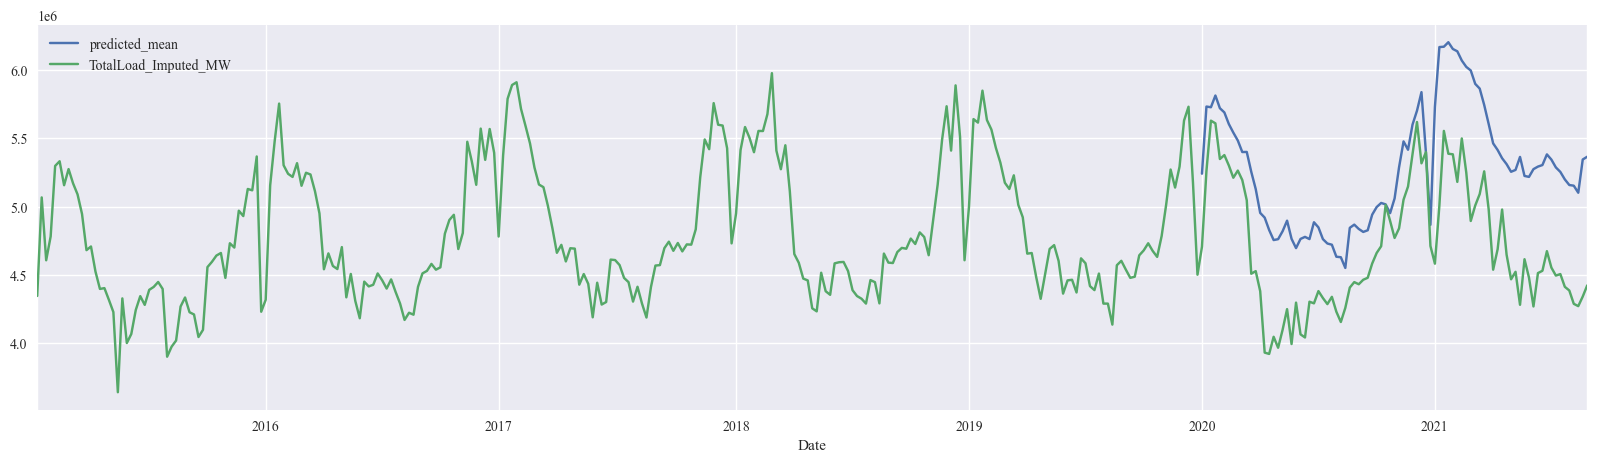

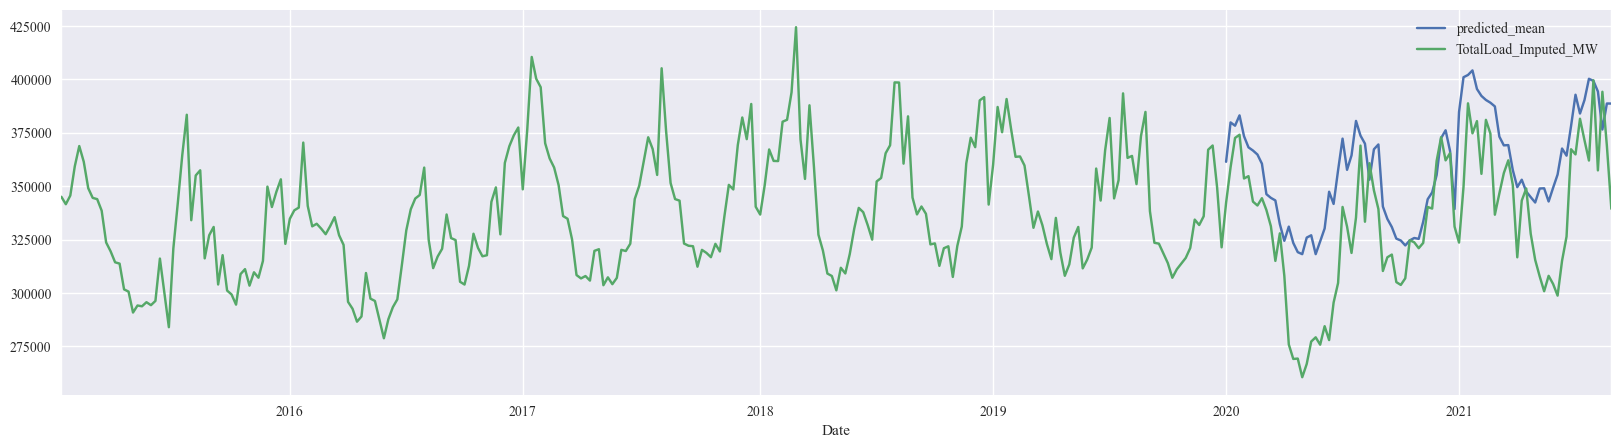

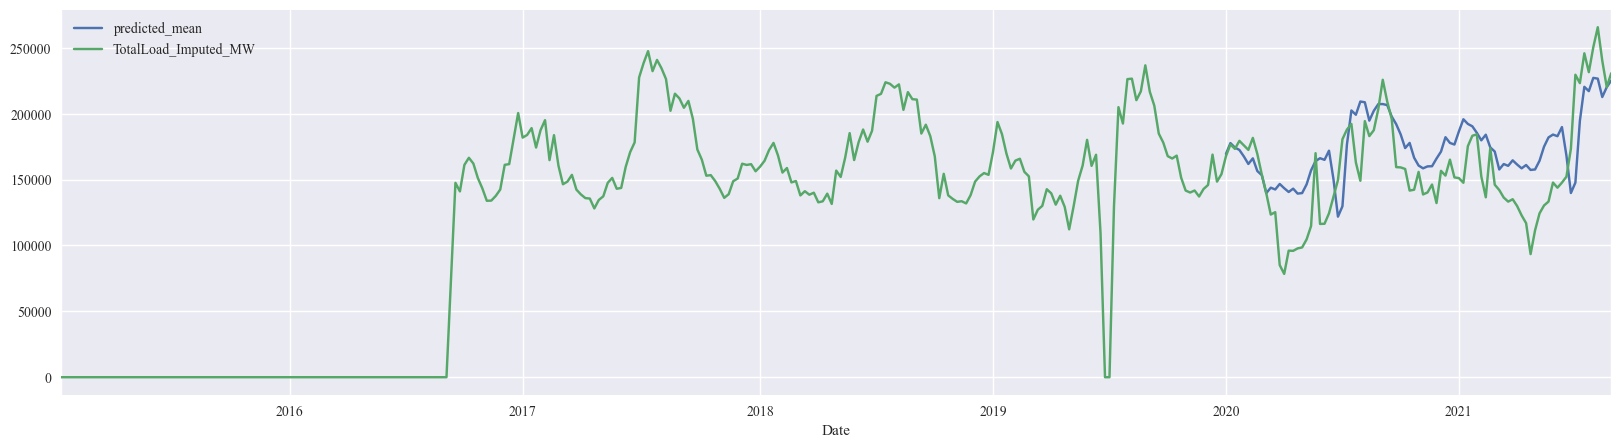

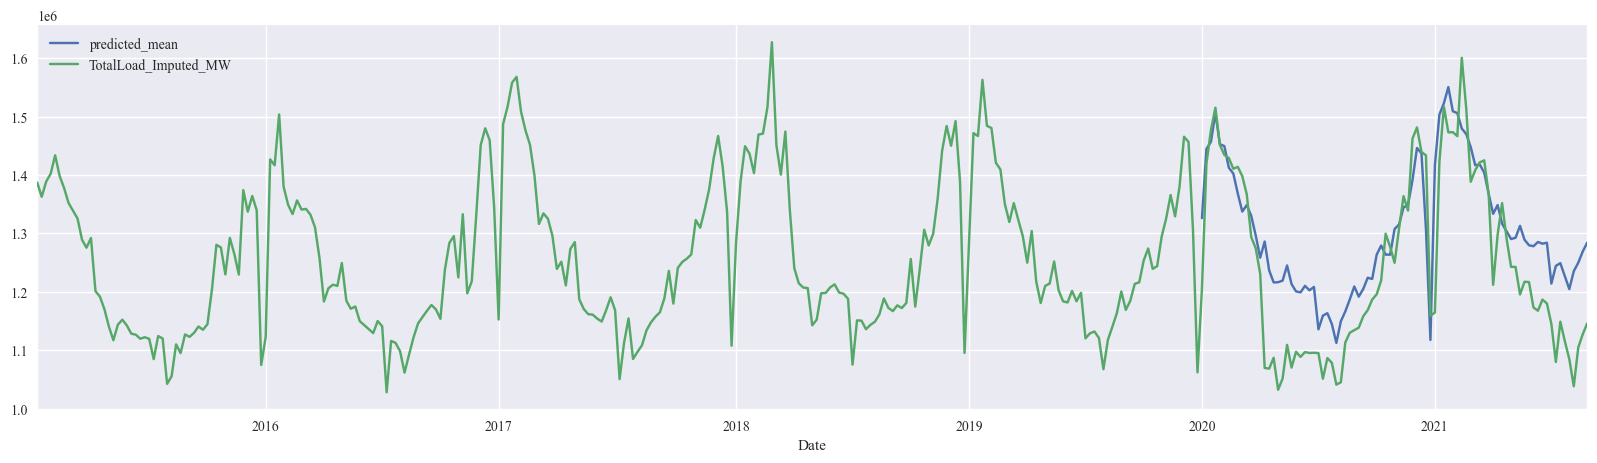

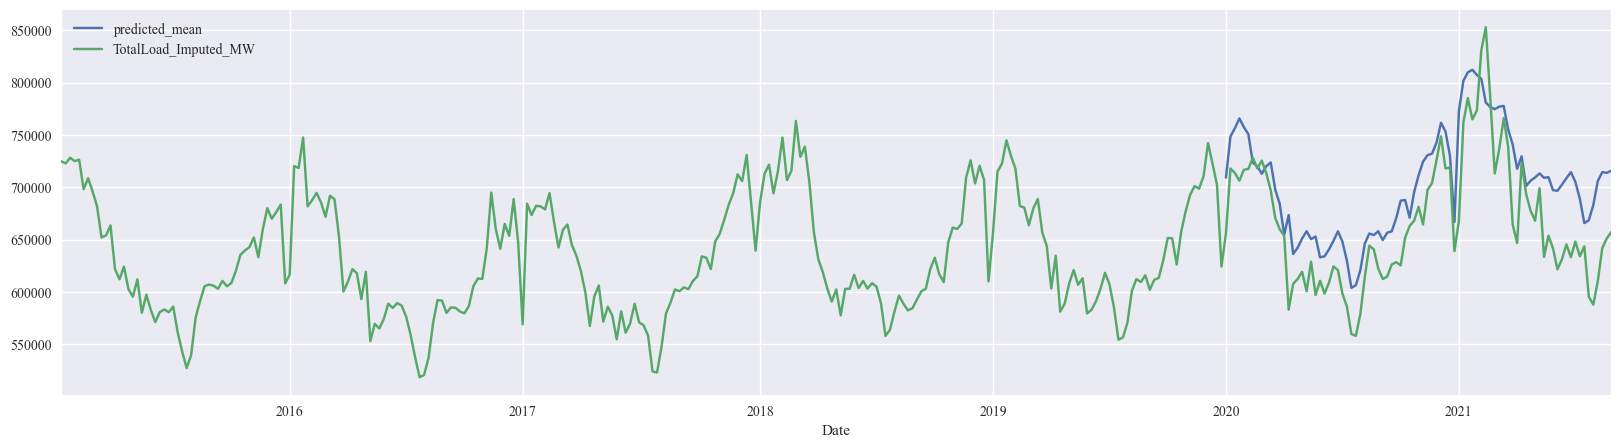

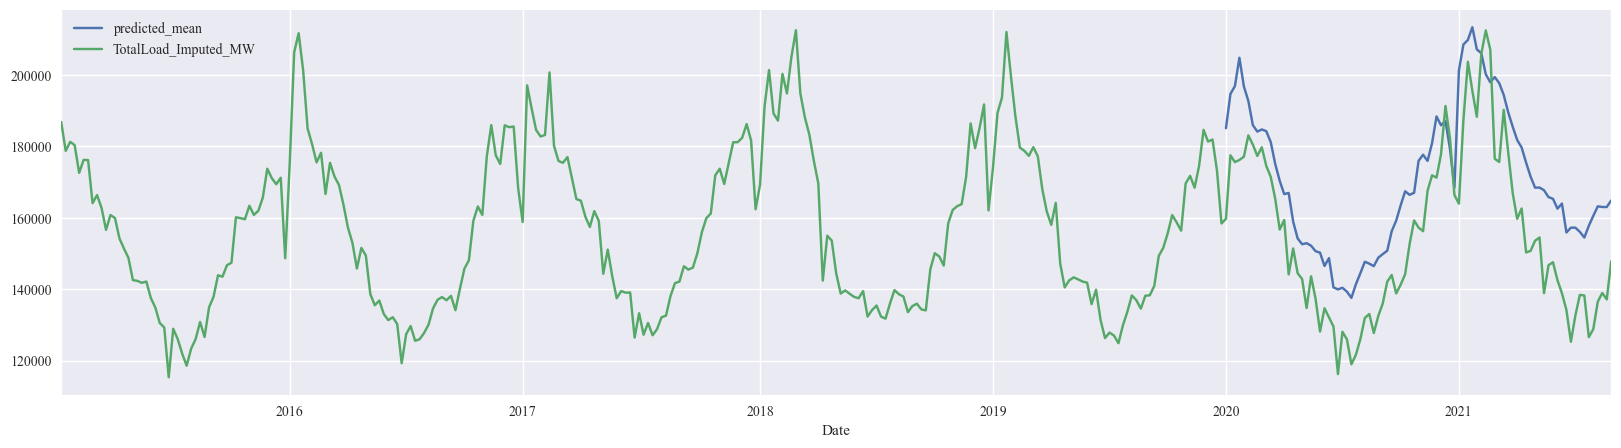

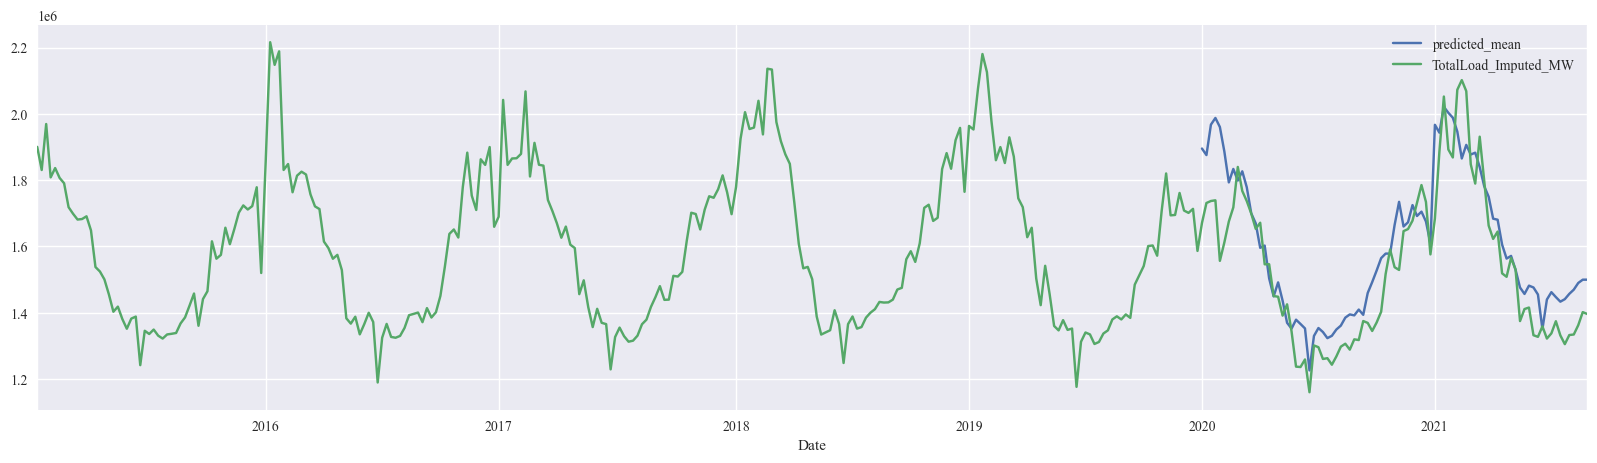

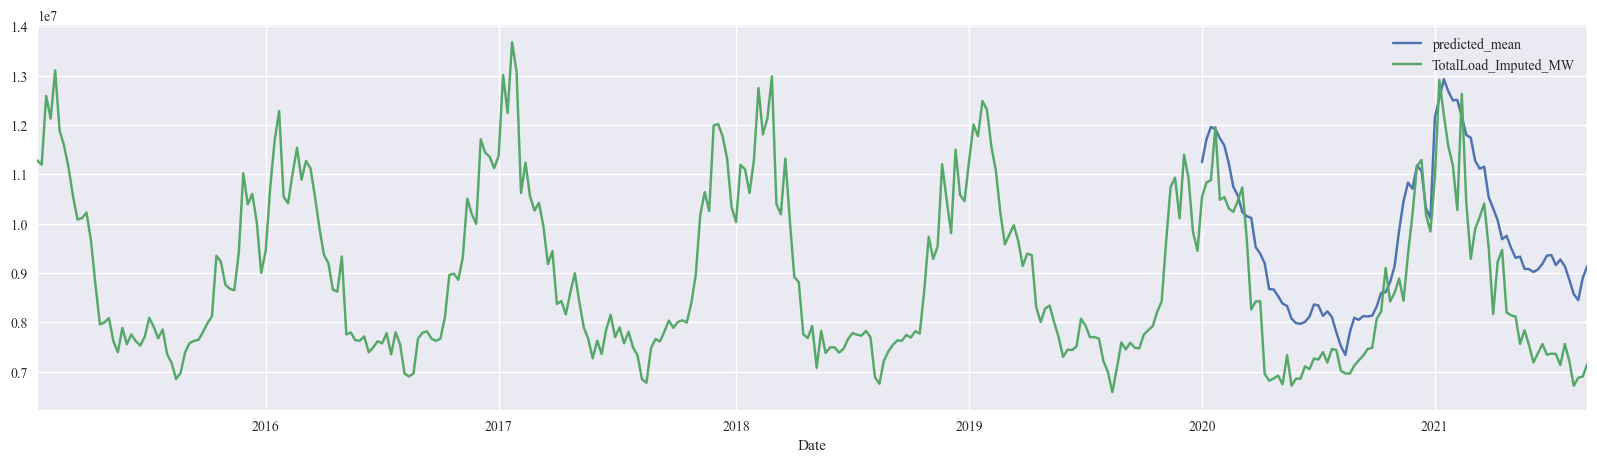

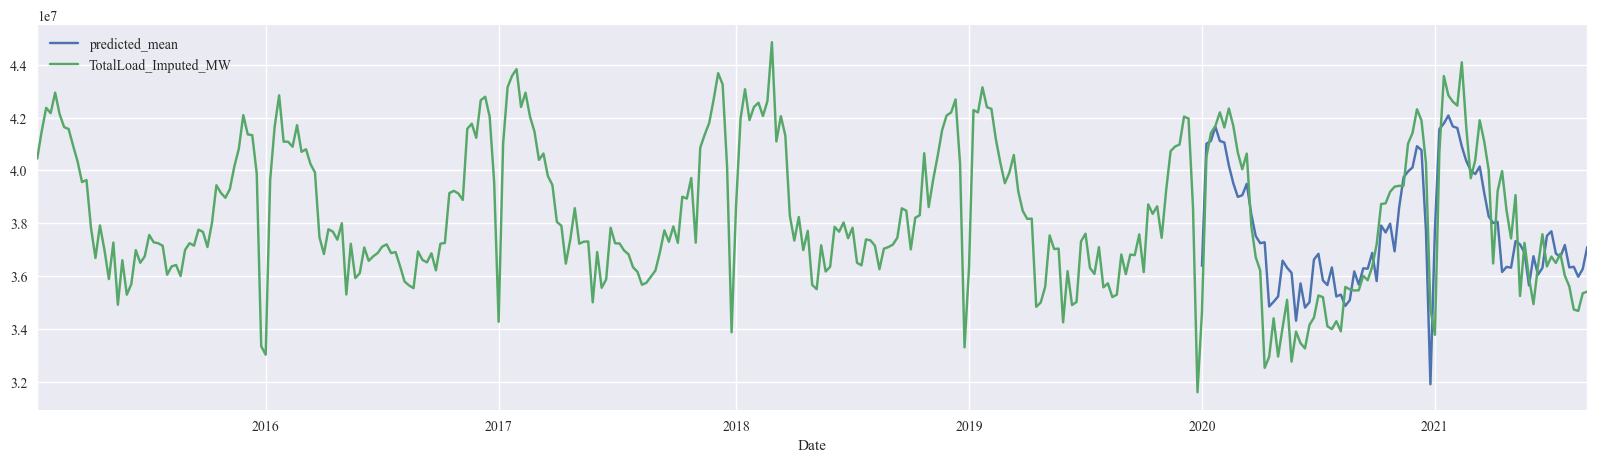

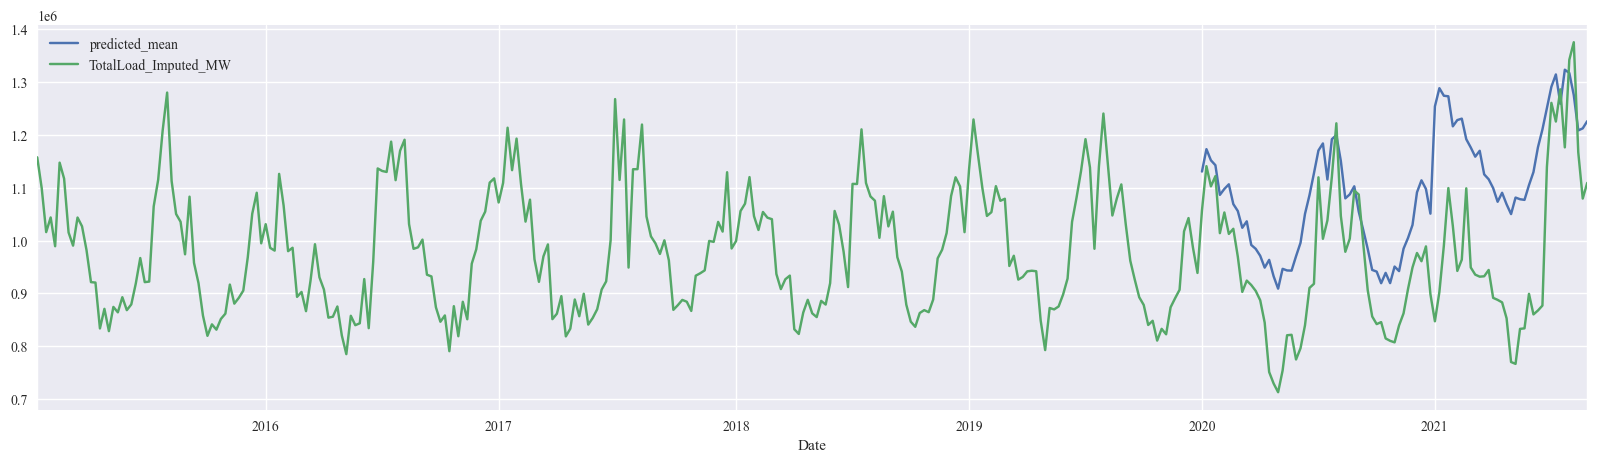

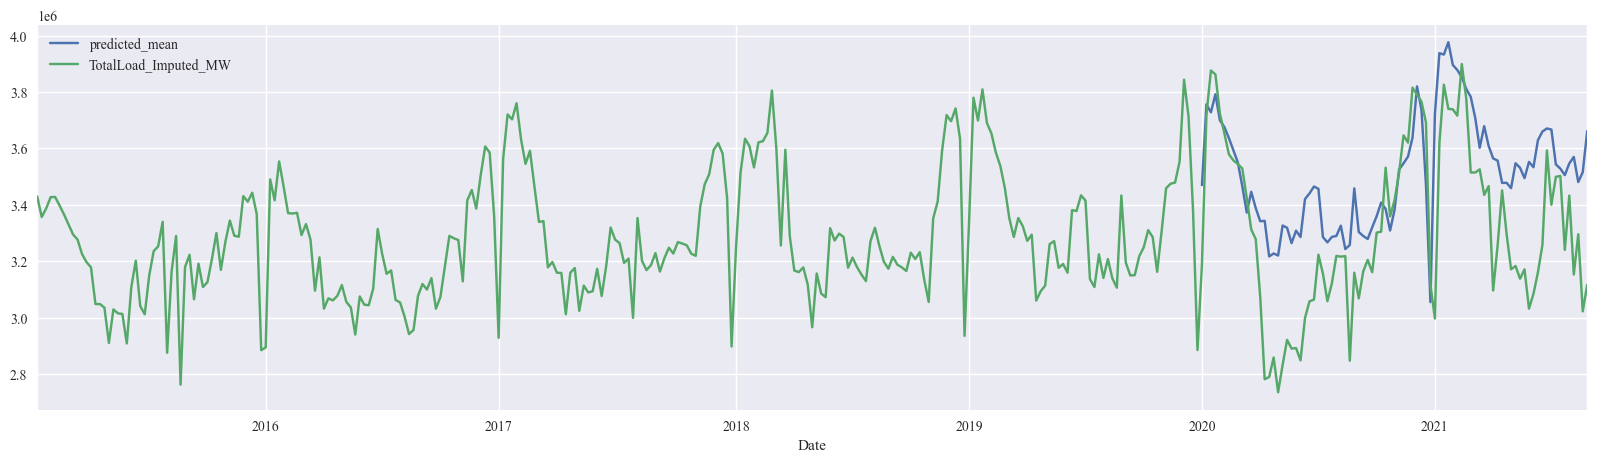

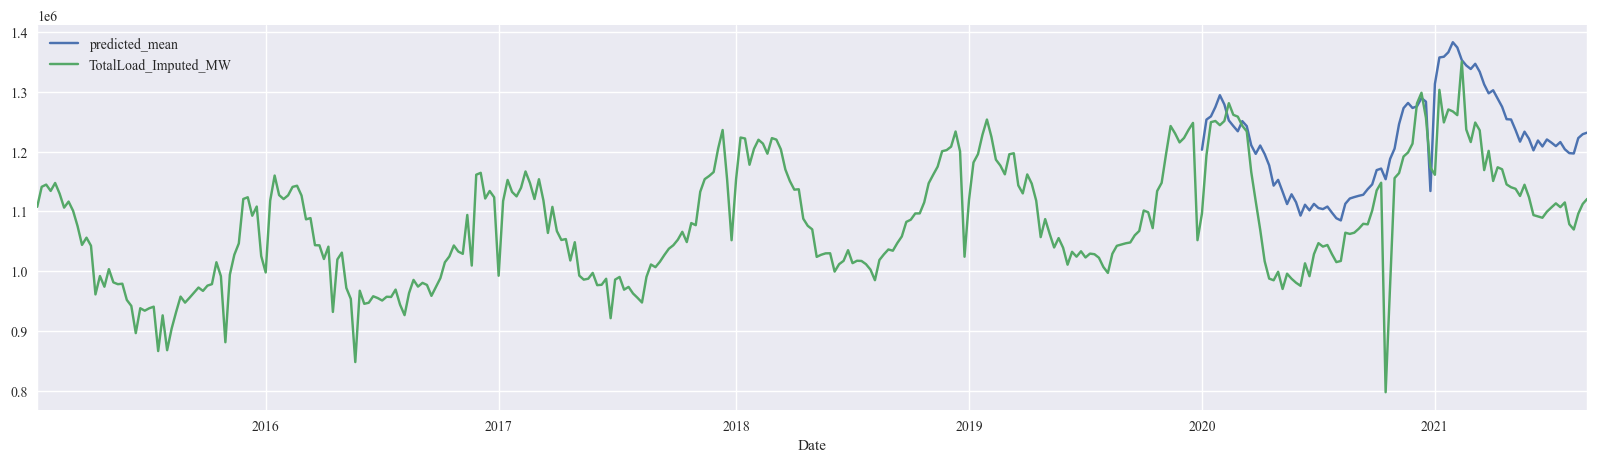

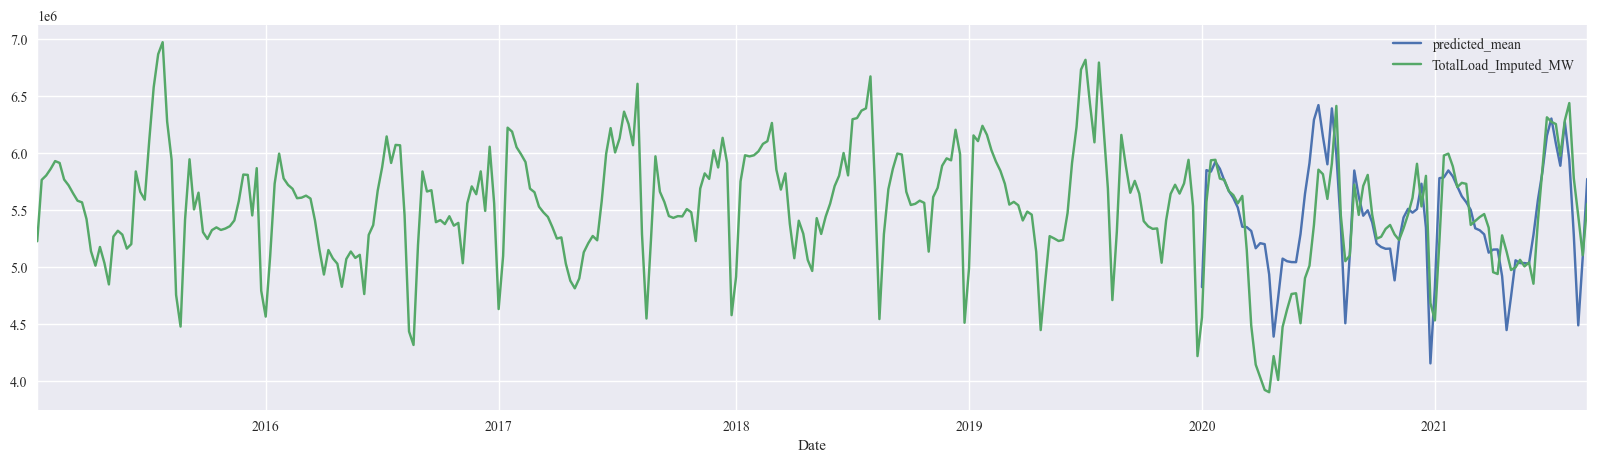

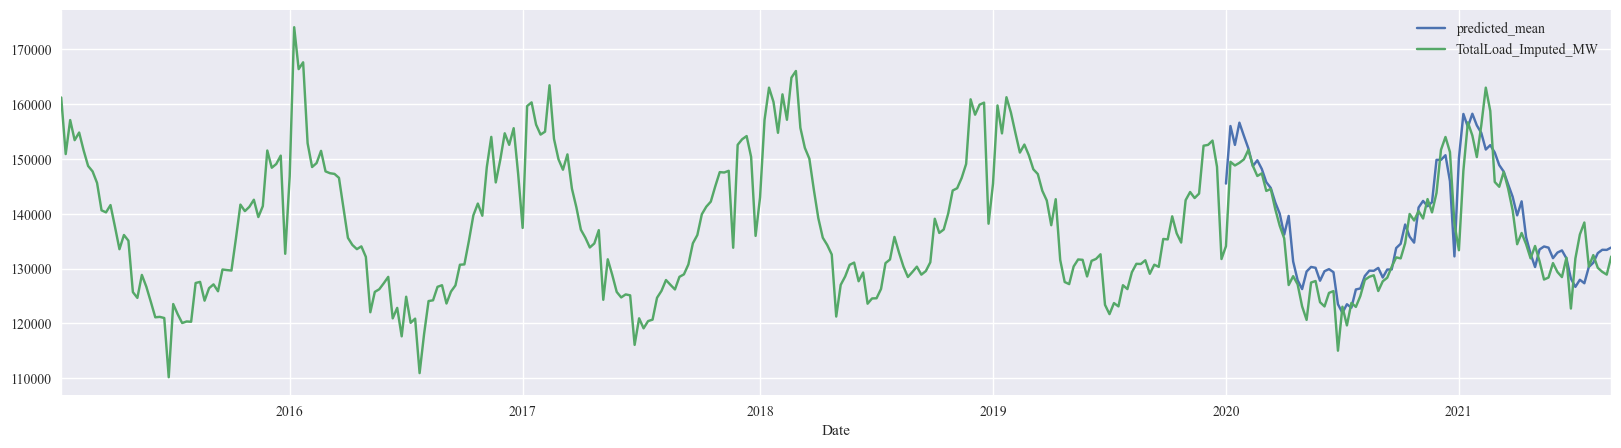

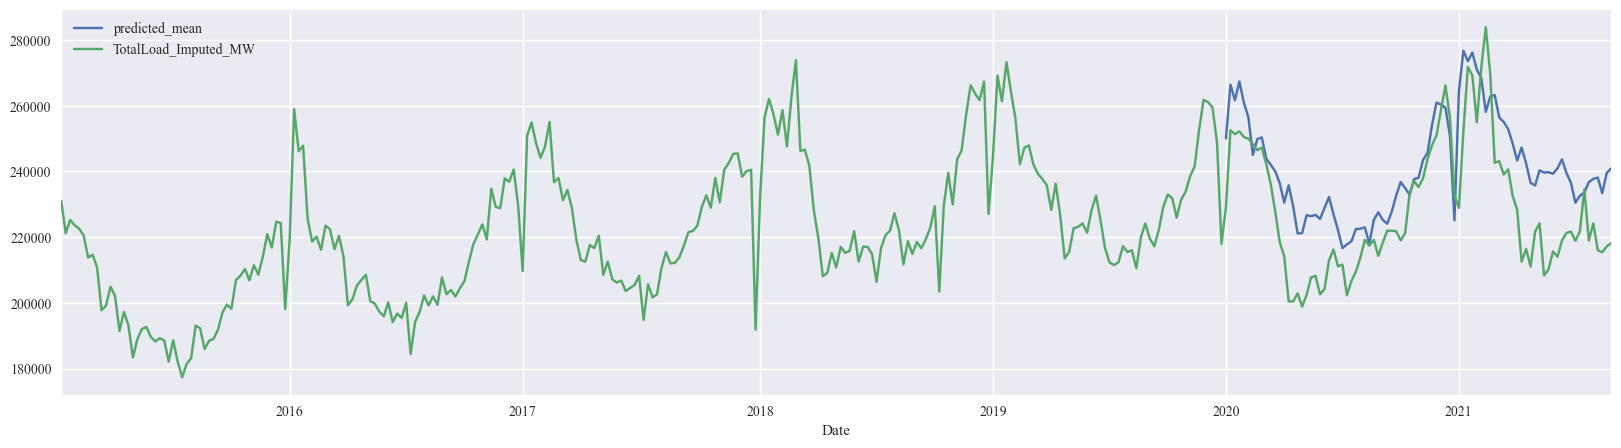

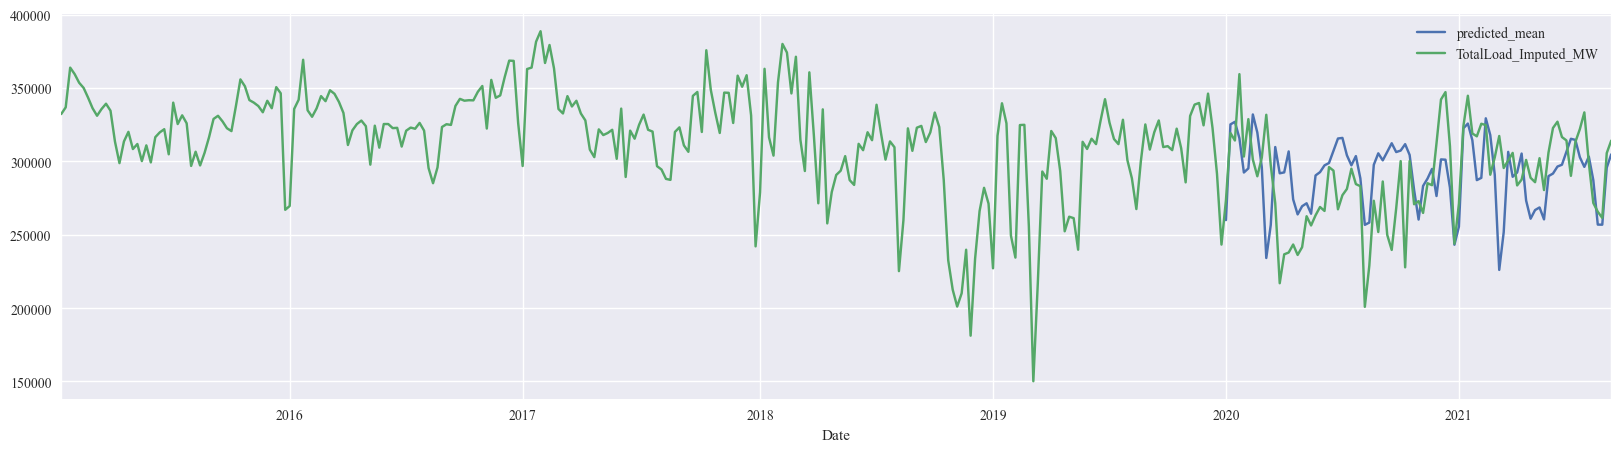

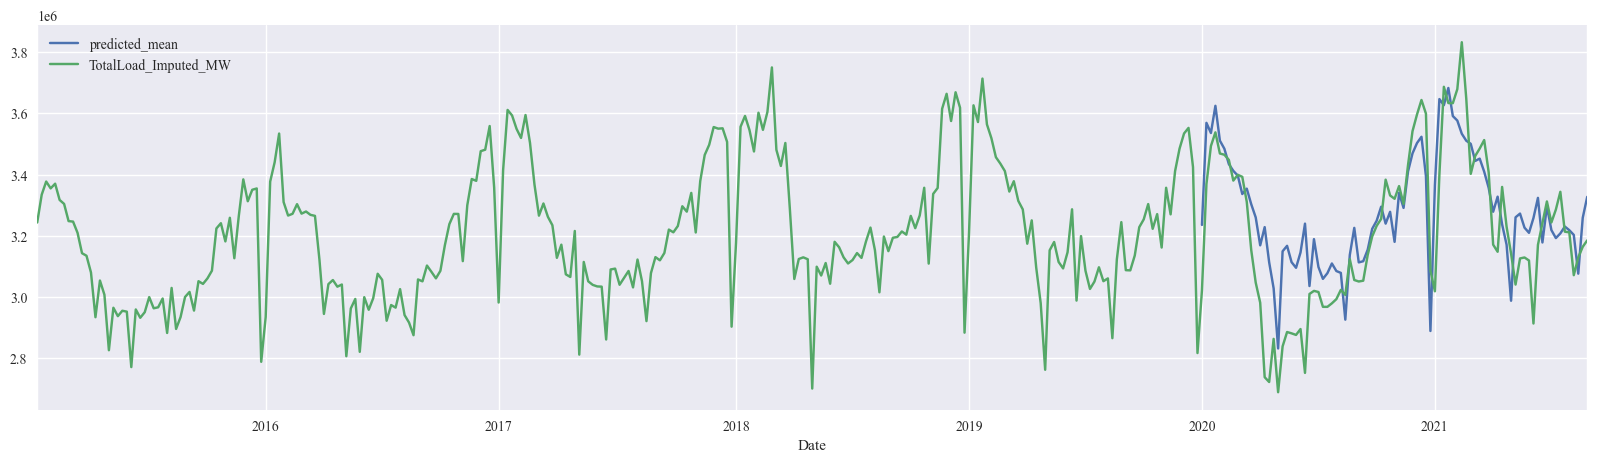

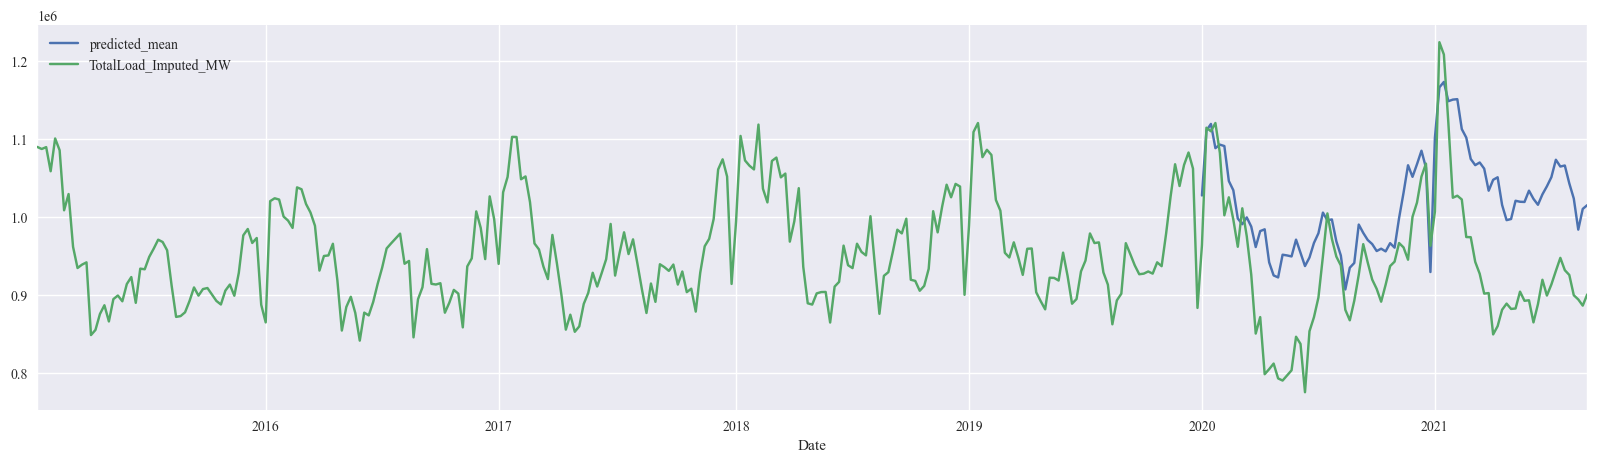

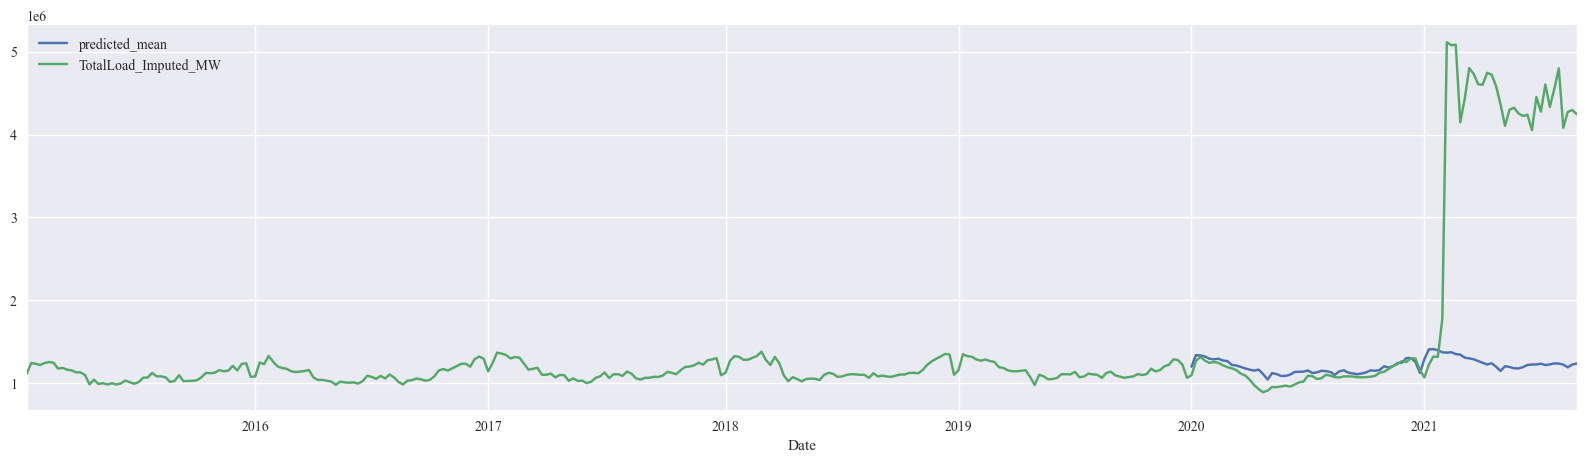

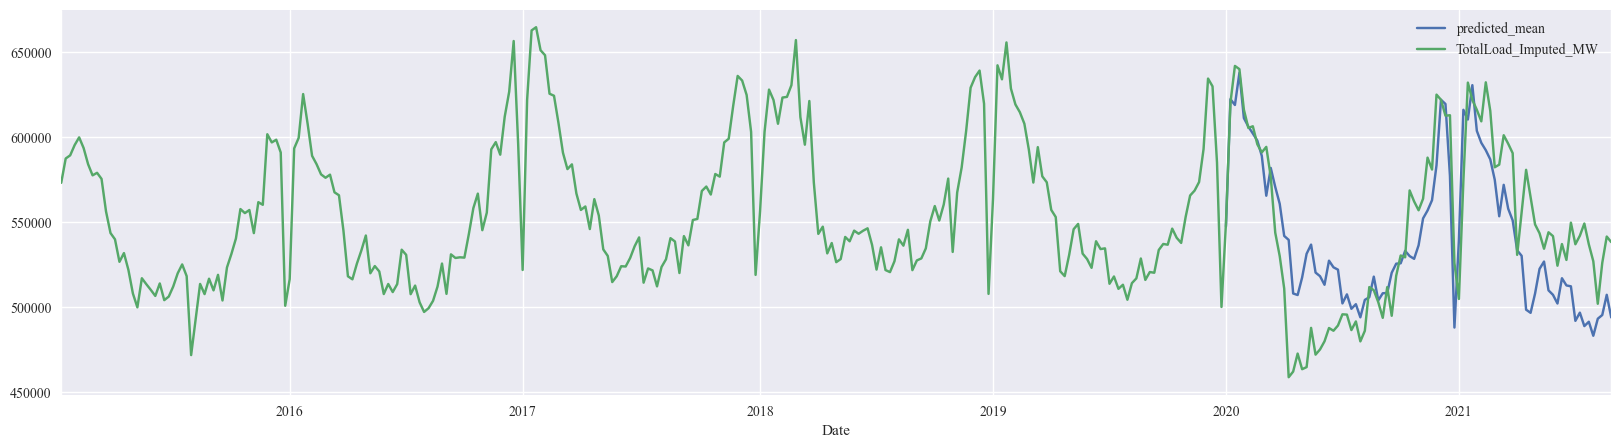

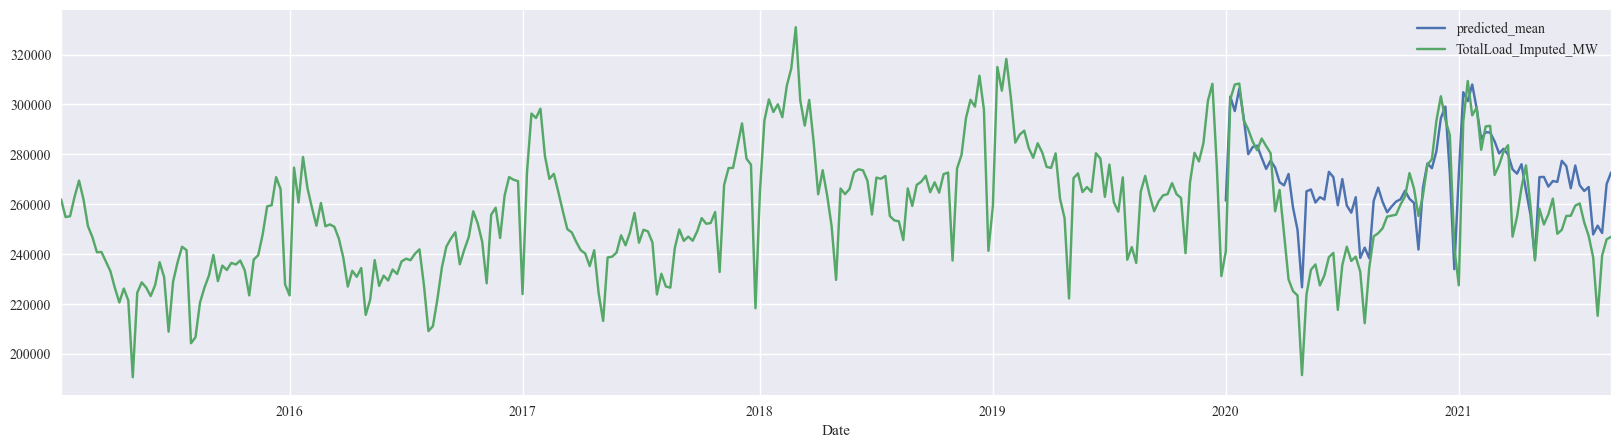

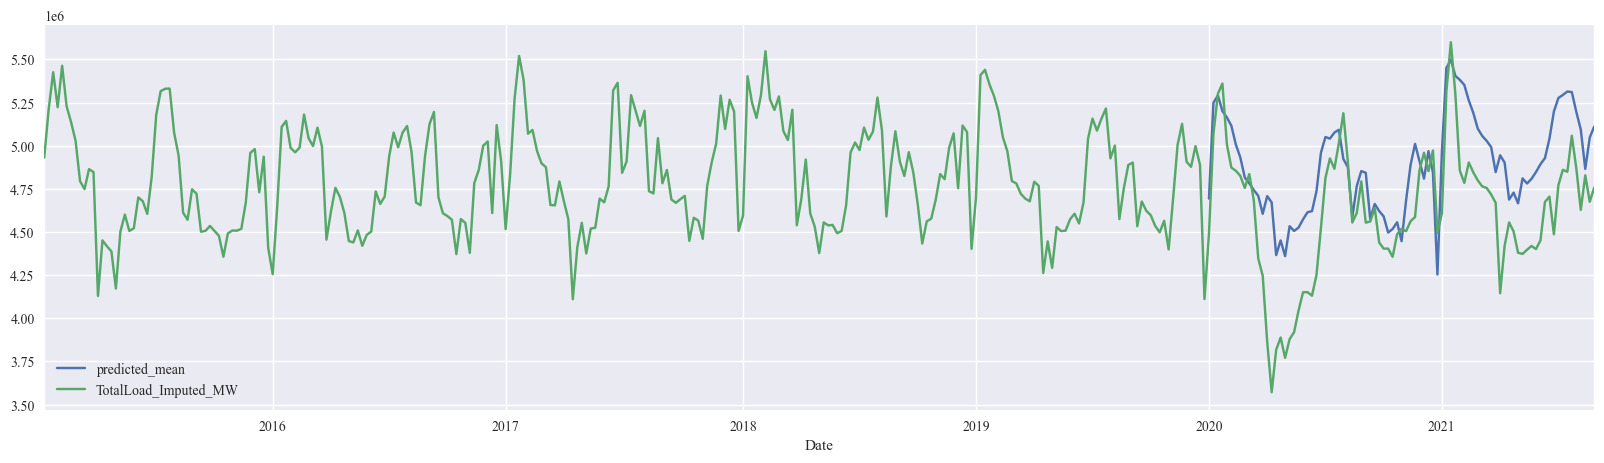

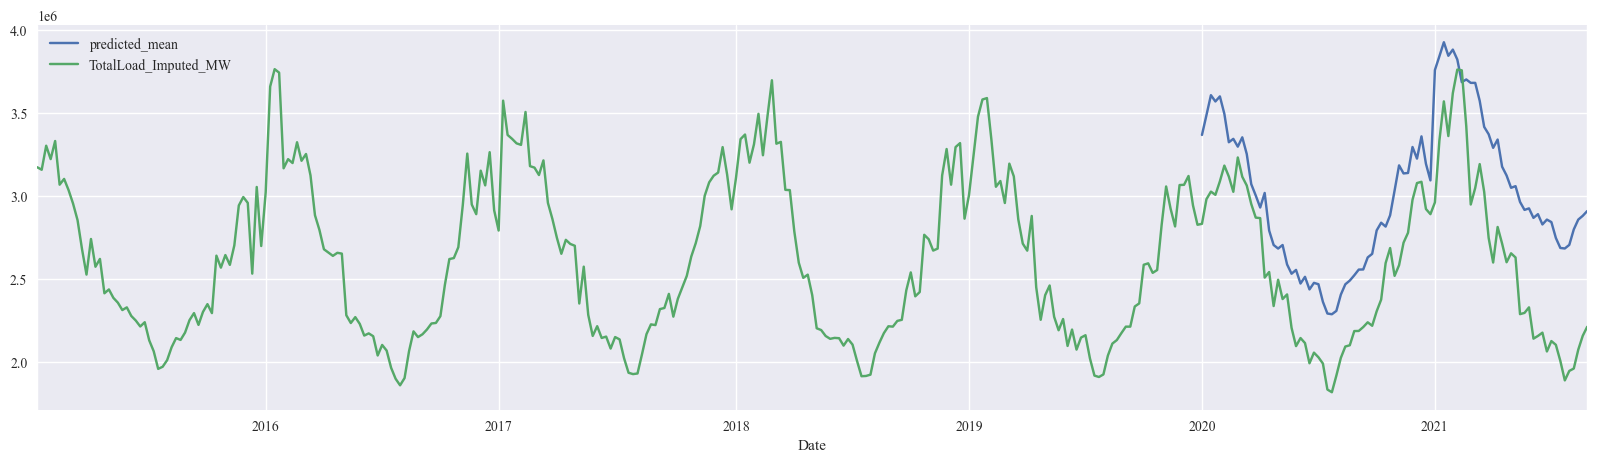

In [19]:
# def sarima_split_best_params_search_fit_predict_plot(country_name, data):
    
#     dataset = data.values
#     train_data = data[data.index <= '2019-12-31']
#     test_data = data[data.index >= '2020-01-01']
    
#     p = range(0, 2)
#     d = range(0, 2)
#     q = range(0, 2)
#     P = range(0, 2)
#     D = range(1, 2)
#     Q = range(0, 2)
#     s = 12

#     best_aic = float("inf")
#     best_params = None

#     for p_val in p:
#         for d_val in d:
#             for q_val in q:
#                 for P_val in P:
#                     for D_val in D:
#                         for Q_val in Q:
#                             try:
#                                 model = SARIMAX(train_data, order=(p_val, d_val, q_val), seasonal_order=(P_val, D_val, Q_val, s))
#                                 fit_model = model.fit()
#                                 aic = fit_model.aic
#                                 if aic < best_aic:
#                                     best_aic = aic
#                                     best_params = (p_val, d_val, q_val, P_val, D_val, Q_val)
#                             except:
#                                 continue

#     print(f"Best SARIMA parameters for {country_name}:", best_params)

#     results = {
#         'country': country_name,
#         'best_params': best_params,
#     }
    
#     try:
#         p_val, d_val, q_val, P_val, D_val, Q_val = best_params
#         s = 52 
#         model = SARIMAX(train_data, order=(p_val, d_val, q_val), seasonal_order=(P_val, D_val, Q_val, s))
#         fit_model = model.fit()
#         yhat = fit_model.predict(start=len(train_data), end=(len(dataset)-1))
    
#         pd.DataFrame(yhat).plot()
#         data.plot(figsize=(20, 5))
#         plt.legend()
#     except TypeError:
#         pass
    
#     return results

# results_list = []

# for country in data_for_the_model['Country'].unique():
#     try: 
#         print(f'Evaluation for country: {country}')
#         country_data = data_for_the_model[data_for_the_model['Country'] == country].set_index('Date').asfreq('W')
#         results = sarima_split_best_params_search_fit_predict_plot(country, country_data["TotalLoad_Imputed_MW"])
#         results_list.append(results)
#     except Exception as e:
#         print(f"An error occurred for country {country}: {e}")

# sarima_best_params = {results['country']: results['best_params'] for results in results_list}

# sarima_best_params_df = pd.DataFrame(results_list)
# display(sarima_best_params_df)

In [20]:
def sarima_fit_predict_plot_evaluate(country_name, country_data, best_params):
    dataset = country_data.values
    train_data = country_data[country_data.index <= '2019-12-31']
    test_data = country_data[country_data.index >= '2020-01-01']
    
    s = 52

    p_val, d_val, q_val, P_val, D_val, Q_val = best_params

    model = SARIMAX(train_data, order=(p_val, d_val, q_val), seasonal_order=(P_val, D_val, Q_val, s))
    fit_model = model.fit()
    yhat = fit_model.predict(start=len(train_data), end=(len(dataset)-1))

    model_filename = f"sarima_model_{country_name}.pkl"
    model_file_path = os.path.join(models_output_folder, model_filename)

    if not os.path.exists(model_file_path):
        with open(model_file_path, 'wb') as model_file:
            pickle.dump(fit_model, model_file)

    plt.style.use('seaborn-v0_8')
    plt.rcParams['font.family'] = 'Times New Roman'
    
    plt.figure(figsize=(20, 5))
    plt.title(f"SARIMA Prediction for Electricity Consumption in Terawatts for Country: {country_name}", fontsize=16)

    yhat_df = pd.DataFrame(yhat)
    country_data_subset = country_data.iloc[1:-1]  
    yhat_df_subset = yhat_df.iloc[1:-1]
    
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(False)  
    formatter.set_powerlimits((-6, 6))  
    plt.gca().yaxis.set_major_formatter(formatter)
    
    plt.plot(yhat_df_subset, color="firebrick", label='Predicted')
    plt.plot(country_data_subset, color='steelblue', label='Actual')
    
    plt.xlim(country_data_subset.index[0], country_data_subset.index[-1])
    plt.legend()
    
    # Changing the Y-axis value labels from 5000000 to 5.0
    plt.gca().set_yticklabels([f'{int(tick) / 1000000:.1f}' for tick in plt.gca().get_yticks()])

    output_file_path = os.path.join(images_output_folder, f"sarima_predictions_{country}.jpeg")
    if not os.path.exists(output_file_path):
        plt.savefig(output_file_path)
    
    plt.close()
    
    MAPE_metric = MAPE(test_data, yhat)
    ME_metric = ME(test_data, yhat)
    MAE_metric = round(mean_absolute_error(test_data, yhat), 2)
    MSE_metric = round(mean_squared_error(test_data, yhat), 2)
    RMSE_metric = RMSE(MSE_metric)

    results = {
        'model': 'sarima',
        'country': country_name,
        'mape': MAPE_metric,
        'me': ME_metric,
        'mae': MAE_metric,
        'mse': MSE_metric,
        'rmse': RMSE_metric
    }
    
    return results

# Dictionary of best SARIMA parameters obtained using sarima_split_best_params_search_fit_predict_plot() function.
sarima_best_params = {
    "Austria": (0, 1, 0, 1, 1, 1),
    "Croatia": (0, 1, 0, 1, 1, 1),
    "Cyprus": (1, 1, 1, 0, 1, 1),
    "Czech Republic": (0, 1, 0, 1, 1, 1),
    "Denmark": (0, 1, 0, 1, 1, 1),
    "Estonia": (0, 1, 0, 1, 1, 1),
    "Finland": (0, 1, 0, 1, 1, 1),
    "France": (0, 1, 0, 1, 1, 1),
    "Germany": (0, 1, 0, 1, 1, 1),
    "Greece": (0, 1, 0, 1, 1, 1),
    "Hungary": (0, 1, 0, 1, 1, 1),
    "Ireland": (0, 1, 0, 1, 1, 1),
    "Italy": (0, 1, 0, 1, 1, 1),
    "Latvia": (0, 1, 0, 1, 1, 1),
    "Lithuania": (0, 1, 1, 1, 1, 1),
    "Luxembourg": (0, 1, 0, 1, 1, 1),
    "Poland": (0, 1, 0, 1, 1, 1),
    "Portugal": (0, 1, 0, 1, 1, 1),
    "Romania": (0, 1, 0, 1, 1, 1),
    "Slovakia": (0, 1, 0, 1, 1, 1),
    "Slovenia": (0, 1, 0, 1, 1, 1),
    "Spain": (0, 1, 0, 1, 1, 1),
    "Sweden": (0, 1, 0, 1, 1, 1)
}


results_list = []

for country in data_for_the_model['Country'].unique():
    try: 
        print(f'Evaluation for country: {country}')
        country_data = data_for_the_model[data_for_the_model['Country'] == country].set_index('Date').asfreq('W')
        best_params = sarima_best_params.get(country)
        if best_params is None:
            print(f"No parameters found for country: {country}")
            continue
        results = sarima_fit_predict_plot_evaluate(country, country_data["TotalLoad_Imputed_MW"], best_params)
        results_list.append(results)
    except Exception as e:
        print(f"An error occurred for country {country}: {e}")

sarima_results = pd.DataFrame(results_list)

Evaluation for country: Austria


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\User\AppData\Local\Temp\ipykernel_3888\2556824105.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{int(tick) / 1000000:.1f}' for tick in plt.gca().get_yticks()])


Evaluation for country: Croatia


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\User\AppData\Local\Temp\ipykernel_3888\2556824105.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{int(tick) / 1000000:.1f}' for tick in plt.gca().get_yticks()])


Evaluation for country: Cyprus


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\User\AppData\Local\Temp\ipykernel_3888\2556824105.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{int(tick) / 1000000:.1f}' for tick in plt.gca().get_yticks()])


Evaluation for country: Czech Republic


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\User\AppData\Local\Temp\ipykernel_3888\2556824105.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{int(tick) / 1000000:.1f}' for tick in plt.gca().get_yticks()])


Evaluation for country: Denmark


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\User\AppData\Local\Temp\ipykernel_3888\2556824105.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{int(tick) / 1000000:.1f}' for tick in plt.gca().get_yticks()])


Evaluation for country: Estonia


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\User\AppData\Local\Temp\ipykernel_3888\2556824105.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{int(tick) / 1000000:.1f}' for tick in plt.gca().get_yticks()])


Evaluation for country: Finland


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\User\AppData\Local\Temp\ipykernel_3888\2556824105.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{int(tick) / 1000000:.1f}' for tick in plt.gca().get_yticks()])


Evaluation for country: France


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\User\AppData\Local\Temp\ipykernel_3888\2556824105.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{int(tick) / 1000000:.1f}' for tick in plt.gca().get_yticks()])


Evaluation for country: Germany


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\User\AppData\Local\Temp\ipykernel_3888\2556824105.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{int(tick) / 1000000:.1f}' for tick in plt.gca().get_yticks()])


Evaluation for country: Greece


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\User\AppData\Local\Temp\ipykernel_3888\2556824105.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{int(tick) / 1000000:.1f}' for tick in plt.gca().get_yticks()])


Evaluation for country: Hungary


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\User\AppData\Local\Temp\ipykernel_3888\2556824105.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{int(tick) / 1000000:.1f}' for tick in plt.gca().get_yticks()])


Evaluation for country: Ireland


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\User\AppData\Local\Temp\ipykernel_3888\2556824105.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{int(tick) / 1000000:.1f}' for tick in plt.gca().get_yticks()])


Evaluation for country: Italy


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\User\AppData\Local\Temp\ipykernel_3888\2556824105.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{int(tick) / 1000000:.1f}' for tick in plt.gca().get_yticks()])


Evaluation for country: Latvia


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\User\AppData\Local\Temp\ipykernel_3888\2556824105.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{int(tick) / 1000000:.1f}' for tick in plt.gca().get_yticks()])
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Evaluation for country: Lithuania


C:\Users\User\AppData\Local\Temp\ipykernel_3888\2556824105.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{int(tick) / 1000000:.1f}' for tick in plt.gca().get_yticks()])


Evaluation for country: Luxembourg


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\User\AppData\Local\Temp\ipykernel_3888\2556824105.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{int(tick) / 1000000:.1f}' for tick in plt.gca().get_yticks()])


Evaluation for country: Poland


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\User\AppData\Local\Temp\ipykernel_3888\2556824105.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{int(tick) / 1000000:.1f}' for tick in plt.gca().get_yticks()])


Evaluation for country: Portugal


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\User\AppData\Local\Temp\ipykernel_3888\2556824105.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{int(tick) / 1000000:.1f}' for tick in plt.gca().get_yticks()])
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Evaluation for country: Romania


C:\Users\User\AppData\Local\Temp\ipykernel_3888\2556824105.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{int(tick) / 1000000:.1f}' for tick in plt.gca().get_yticks()])


Evaluation for country: Slovakia


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\User\AppData\Local\Temp\ipykernel_3888\2556824105.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{int(tick) / 1000000:.1f}' for tick in plt.gca().get_yticks()])
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Evaluation for country: Slovenia


C:\Users\User\AppData\Local\Temp\ipykernel_3888\2556824105.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{int(tick) / 1000000:.1f}' for tick in plt.gca().get_yticks()])


Evaluation for country: Spain


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\User\AppData\Local\Temp\ipykernel_3888\2556824105.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{int(tick) / 1000000:.1f}' for tick in plt.gca().get_yticks()])


Evaluation for country: Sweden


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\User\AppData\Local\Temp\ipykernel_3888\2556824105.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{int(tick) / 1000000:.1f}' for tick in plt.gca().get_yticks()])


# TBATS

### Searching for optimal parameters 

The **tbats_split_best_params_search_fit_predict()** function was employed to discover the optimal parameters for TBATS models for each country, as well as to evaluate the model performance using the selected parameters.

In [22]:
# tbats_best_params = {}

# def tbats_split_best_params_search_fit_predict(country_name, data):
    
#     dataset = data.values
#     train_data = data[data.index <= '2019-12-31']
#     test_data = data[data.index >= '2020-01-01']
    
#     seasonal_periods = 52
#     use_arma_errors = True
#     use_box_cox_options = [True, False]
#     use_trend_options = [True, False]
#     n_jobs_option = os.cpu_count()
#     use_damped_trend = True
    
#     best_aic = float("inf")
#     best_params = None
#     best_result_dict = None

#     for use_box_cox in use_box_cox_options:
#         for use_trend in use_trend_options:
#             try:
#                 model = TBATS(seasonal_periods=[seasonal_periods],
#                               use_arma_errors=use_arma_errors,
#                               use_box_cox=use_box_cox,
#                               use_trend=use_trend,
#                               n_jobs=n_jobs_option,
#                               use_damped_trend=use_damped_trend
#                              )
#                 fit_model = model.fit(train_data)
#                 aic = fit_model.aic
#                 if aic < best_aic:
#                     best_aic = aic
#                     best_params = (
#                         seasonal_periods, 
#                         use_arma_errors, 
#                         use_box_cox,
#                         use_trend, 
#                         n_jobs_option,
#                         use_damped_trend
#                         )
#                     best_result_dict = {
#                     "country": country_name,
#                     "seasonal_period": seasonal_periods,
#                     "use_arma_errors": use_arma_errors,
#                     "use_box_cox": use_box_cox,
#                     "use_trend": use_trend,
#                     "use_damped_trend": use_damped_trend
#                 }
#             except:
#                 continue

#     tbats_best_params[country_name] = best_result_dict

#     print(f'Best params for country {country_name}: {best_params}')
    
#     results = {
#         'country': country_name,
#         'best_params': best_params,
#     }
    
#     return(results)

# results_list = []

# for country in data_for_the_model['Country'].unique():
#     try: 
#         print(f'Evaluation for country: {country}')
#         country_data = data_for_the_model[data_for_the_model['Country'] == country].set_index('Date').asfreq('W')
#         results = tbats_split_best_params_search_fit_predict(country, country_data["TotalLoad_Imputed_MW"])
#         results_list.append(results)
#     except Exception as e:
#         print(f"An error occurred for country {country}: {e}")

# tbats_best_params = {results['country']: results['best_params'] for results in results_list}

# tbats_best_params_df = pd.DataFrame(results_list)
# display(tbats_best_params_df)

Evaluation for country: Austria


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tbats\error\ExceptionHandler.py:13: InputArgsWarning: When use_damped_trend can be used only with use_trend. Setting damped trend to False.
  warnings.warn(message, warning_type)
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tbats\error\ExceptionHandler.py:13: InputArgsWarning: When use_damped_trend can be used only with use_trend. Setting damped trend to False.
  warnings.warn(message, warning_type)


Best params for country Austria: (52, True, False, True, 4, True)
Evaluation for country: Croatia


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tbats\error\ExceptionHandler.py:13: InputArgsWarning: When use_damped_trend can be used only with use_trend. Setting damped trend to False.
  warnings.warn(message, warning_type)
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tbats\error\ExceptionHandler.py:13: InputArgsWarning: When use_damped_trend can be used only with use_trend. Setting damped trend to False.
  warnings.warn(message, warning_type)


Best params for country Croatia: (52, True, True, False, 4, True)
Evaluation for country: Cyprus


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tbats\error\ExceptionHandler.py:13: InputArgsWarning: Box-Cox transformation (use_box_cox) was forced to True but there are negative values in input series. Setting use_box_cox to False.
  warnings.warn(message, warning_type)
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tbats\error\ExceptionHandler.py:13: InputArgsWarning: When use_damped_trend can be used only with use_trend. Setting damped trend to False.
  warnings.warn(message, warning_type)
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tbats\error\ExceptionHandler.py:13: InputArgsWarning: Box-Cox transformation (use_box_cox) was forced to True but there are negative values in input series. Setting use_box_cox to False.
  warnings.warn(message, warning_type)
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tbats\error\ExceptionHandler.py:13: InputArgsWarning: When use_damped_trend can b

Best params for country Cyprus: (52, True, True, False, 4, True)
Evaluation for country: Czech Republic


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tbats\error\ExceptionHandler.py:13: InputArgsWarning: When use_damped_trend can be used only with use_trend. Setting damped trend to False.
  warnings.warn(message, warning_type)
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tbats\error\ExceptionHandler.py:13: InputArgsWarning: When use_damped_trend can be used only with use_trend. Setting damped trend to False.
  warnings.warn(message, warning_type)


Best params for country Czech Republic: (52, True, True, True, 4, True)
Evaluation for country: Denmark


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tbats\error\ExceptionHandler.py:13: InputArgsWarning: When use_damped_trend can be used only with use_trend. Setting damped trend to False.
  warnings.warn(message, warning_type)
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tbats\error\ExceptionHandler.py:13: InputArgsWarning: When use_damped_trend can be used only with use_trend. Setting damped trend to False.
  warnings.warn(message, warning_type)


Best params for country Denmark: (52, True, True, False, 4, True)
Evaluation for country: Estonia


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tbats\error\ExceptionHandler.py:13: InputArgsWarning: When use_damped_trend can be used only with use_trend. Setting damped trend to False.
  warnings.warn(message, warning_type)
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tbats\error\ExceptionHandler.py:13: InputArgsWarning: When use_damped_trend can be used only with use_trend. Setting damped trend to False.
  warnings.warn(message, warning_type)


Best params for country Estonia: (52, True, True, False, 4, True)
Evaluation for country: Finland


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tbats\error\ExceptionHandler.py:13: InputArgsWarning: When use_damped_trend can be used only with use_trend. Setting damped trend to False.
  warnings.warn(message, warning_type)
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tbats\error\ExceptionHandler.py:13: InputArgsWarning: When use_damped_trend can be used only with use_trend. Setting damped trend to False.
  warnings.warn(message, warning_type)


Best params for country Finland: (52, True, True, False, 4, True)
Evaluation for country: France


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tbats\error\ExceptionHandler.py:13: InputArgsWarning: When use_damped_trend can be used only with use_trend. Setting damped trend to False.
  warnings.warn(message, warning_type)
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tbats\error\ExceptionHandler.py:13: InputArgsWarning: When use_damped_trend can be used only with use_trend. Setting damped trend to False.
  warnings.warn(message, warning_type)


Best params for country France: (52, True, True, True, 4, True)
Evaluation for country: Germany


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tbats\error\ExceptionHandler.py:13: InputArgsWarning: When use_damped_trend can be used only with use_trend. Setting damped trend to False.
  warnings.warn(message, warning_type)
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tbats\error\ExceptionHandler.py:13: InputArgsWarning: When use_damped_trend can be used only with use_trend. Setting damped trend to False.
  warnings.warn(message, warning_type)


Best params for country Germany: (52, True, False, False, 4, True)
Evaluation for country: Greece


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tbats\error\ExceptionHandler.py:13: InputArgsWarning: When use_damped_trend can be used only with use_trend. Setting damped trend to False.
  warnings.warn(message, warning_type)
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tbats\error\ExceptionHandler.py:13: InputArgsWarning: When use_damped_trend can be used only with use_trend. Setting damped trend to False.
  warnings.warn(message, warning_type)


Best params for country Greece: (52, True, True, False, 4, True)
Evaluation for country: Hungary


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tbats\error\ExceptionHandler.py:13: InputArgsWarning: When use_damped_trend can be used only with use_trend. Setting damped trend to False.
  warnings.warn(message, warning_type)
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tbats\error\ExceptionHandler.py:13: InputArgsWarning: When use_damped_trend can be used only with use_trend. Setting damped trend to False.
  warnings.warn(message, warning_type)


Best params for country Hungary: (52, True, False, False, 4, True)
Evaluation for country: Ireland


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tbats\error\ExceptionHandler.py:13: InputArgsWarning: When use_damped_trend can be used only with use_trend. Setting damped trend to False.
  warnings.warn(message, warning_type)
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tbats\error\ExceptionHandler.py:13: InputArgsWarning: When use_damped_trend can be used only with use_trend. Setting damped trend to False.
  warnings.warn(message, warning_type)


Best params for country Ireland: (52, True, False, False, 4, True)
Evaluation for country: Italy


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tbats\error\ExceptionHandler.py:13: InputArgsWarning: When use_damped_trend can be used only with use_trend. Setting damped trend to False.
  warnings.warn(message, warning_type)
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tbats\error\ExceptionHandler.py:13: InputArgsWarning: When use_damped_trend can be used only with use_trend. Setting damped trend to False.
  warnings.warn(message, warning_type)


Best params for country Italy: (52, True, True, False, 4, True)
Evaluation for country: Latvia


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tbats\error\ExceptionHandler.py:13: InputArgsWarning: When use_damped_trend can be used only with use_trend. Setting damped trend to False.
  warnings.warn(message, warning_type)
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tbats\error\ExceptionHandler.py:13: InputArgsWarning: When use_damped_trend can be used only with use_trend. Setting damped trend to False.
  warnings.warn(message, warning_type)


Best params for country Latvia: (52, True, True, False, 4, True)
Evaluation for country: Lithuania


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tbats\error\ExceptionHandler.py:13: InputArgsWarning: When use_damped_trend can be used only with use_trend. Setting damped trend to False.
  warnings.warn(message, warning_type)
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tbats\error\ExceptionHandler.py:13: InputArgsWarning: When use_damped_trend can be used only with use_trend. Setting damped trend to False.
  warnings.warn(message, warning_type)


Best params for country Lithuania: (52, True, True, True, 4, True)
Evaluation for country: Luxembourg


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tbats\error\ExceptionHandler.py:13: InputArgsWarning: When use_damped_trend can be used only with use_trend. Setting damped trend to False.
  warnings.warn(message, warning_type)
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tbats\error\ExceptionHandler.py:13: InputArgsWarning: When use_damped_trend can be used only with use_trend. Setting damped trend to False.
  warnings.warn(message, warning_type)


Best params for country Luxembourg: (52, True, False, False, 4, True)
Evaluation for country: Poland


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tbats\error\ExceptionHandler.py:13: InputArgsWarning: When use_damped_trend can be used only with use_trend. Setting damped trend to False.
  warnings.warn(message, warning_type)
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tbats\error\ExceptionHandler.py:13: InputArgsWarning: When use_damped_trend can be used only with use_trend. Setting damped trend to False.
  warnings.warn(message, warning_type)


Best params for country Poland: (52, True, False, False, 4, True)
Evaluation for country: Portugal


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tbats\error\ExceptionHandler.py:13: InputArgsWarning: When use_damped_trend can be used only with use_trend. Setting damped trend to False.
  warnings.warn(message, warning_type)
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tbats\error\ExceptionHandler.py:13: InputArgsWarning: When use_damped_trend can be used only with use_trend. Setting damped trend to False.
  warnings.warn(message, warning_type)


Best params for country Portugal: (52, True, False, False, 4, True)
Evaluation for country: Romania


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tbats\error\ExceptionHandler.py:13: InputArgsWarning: When use_damped_trend can be used only with use_trend. Setting damped trend to False.
  warnings.warn(message, warning_type)
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tbats\error\ExceptionHandler.py:13: InputArgsWarning: When use_damped_trend can be used only with use_trend. Setting damped trend to False.
  warnings.warn(message, warning_type)


Best params for country Romania: (52, True, True, True, 4, True)
Evaluation for country: Slovakia


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tbats\error\ExceptionHandler.py:13: InputArgsWarning: When use_damped_trend can be used only with use_trend. Setting damped trend to False.
  warnings.warn(message, warning_type)
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tbats\error\ExceptionHandler.py:13: InputArgsWarning: When use_damped_trend can be used only with use_trend. Setting damped trend to False.
  warnings.warn(message, warning_type)


Best params for country Slovakia: (52, True, True, True, 4, True)
Evaluation for country: Slovenia


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tbats\error\ExceptionHandler.py:13: InputArgsWarning: When use_damped_trend can be used only with use_trend. Setting damped trend to False.
  warnings.warn(message, warning_type)
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tbats\error\ExceptionHandler.py:13: InputArgsWarning: When use_damped_trend can be used only with use_trend. Setting damped trend to False.
  warnings.warn(message, warning_type)


Best params for country Slovenia: (52, True, True, False, 4, True)
Evaluation for country: Spain


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tbats\error\ExceptionHandler.py:13: InputArgsWarning: When use_damped_trend can be used only with use_trend. Setting damped trend to False.
  warnings.warn(message, warning_type)
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tbats\error\ExceptionHandler.py:13: InputArgsWarning: When use_damped_trend can be used only with use_trend. Setting damped trend to False.
  warnings.warn(message, warning_type)


Best params for country Spain: (52, True, True, True, 4, True)
Evaluation for country: Sweden


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tbats\error\ExceptionHandler.py:13: InputArgsWarning: When use_damped_trend can be used only with use_trend. Setting damped trend to False.
  warnings.warn(message, warning_type)
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tbats\error\ExceptionHandler.py:13: InputArgsWarning: When use_damped_trend can be used only with use_trend. Setting damped trend to False.
  warnings.warn(message, warning_type)


Best params for country Sweden: (52, True, True, False, 4, True)


country                        best_params
0          Austria   (52, True, False, True, 4, True)
1          Croatia   (52, True, True, False, 4, True)
2           Cyprus   (52, True, True, False, 4, True)
3   Czech Republic    (52, True, True, True, 4, True)
4          Denmark   (52, True, True, False, 4, True)
5          Estonia   (52, True, True, False, 4, True)
6          Finland   (52, True, True, False, 4, True)
7           France    (52, True, True, True, 4, True)
8          Germany  (52, True, False, False, 4, True)
9           Greece   (52, True, True, False, 4, True)
10         Hungary  (52, True, False, False, 4, True)
11         Ireland  (52, True, False, False, 4, True)
12           Italy   (52, True, True, False, 4, True)
13          Latvia   (52, True, True, False, 4, True)
14       Lithuania    (52, True, True, True, 4, True)
15      Luxembourg  (52, True, False, False, 4, True)
16          Poland  (52, True, False, False, 4, True)
17        Portugal  (52, True, False, False, 4, True)
18         Romania    (52, True, True, True, 4, True)
19        Slovakia    (52, True, True, True, 4, True)
20        Slovenia   (52, True, True, False, 4, True)
21           Spain    (52, True, True, True, 4, True)
22          Sweden   (52, True, True, False, 4, True)

In [36]:
def tbats_fit_predict_plot_evaluate(country_name, country_data, best_params):

    dataset = country_data.values
    train_data = country_data[country_data.index <= '2019-12-31']
    test_data = country_data[country_data.index >= '2020-01-01']

    (
    seasonal_period, 
    use_arma_errors, 
    use_box_cox,
    use_trend, 
    n_jobs_option,
    use_damped_trend
    ) = best_params
    
    model = TBATS(seasonal_periods=[seasonal_period],
                                    use_arma_errors=use_arma_errors,
                                    use_box_cox=use_box_cox,
                                    use_trend=use_trend,
                                    n_jobs=n_jobs_option,
                                    use_damped_trend=use_damped_trend
                                    )
    fit_model = model.fit(train_data)
    yhat = fit_model.forecast(steps=len(test_data))

    model_filename = f"tbats_model_{country_name}.pkl"
    model_file_path = os.path.join(models_output_folder, model_filename)

    if not os.path.exists(model_file_path):
        with open(model_file_path, 'wb') as model_file:
            pickle.dump(fit_model, model_file)

    start_date = '2020-01-07'
    end_date = '2021-09-05'
    date_range = pd.date_range(start=start_date, end=end_date, freq='7D')

    yhat_df = pd.DataFrame(yhat, index=date_range)
    yhat_df_subset = yhat_df.iloc[1:-1]

    country_data_subset = country_data.iloc[1:-1] 

    plt.style.use('seaborn-v0_8')
    plt.rcParams['font.family'] = 'Times New Roman'
    
    plt.figure(figsize=(20, 5))
    plt.title(f"TBATS Prediction for Electricity Consumption in Terawatts for Country: {country_name}", fontsize=16)
    
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(False)
    formatter.set_powerlimits((-6, 6))
    plt.gca().yaxis.set_major_formatter(formatter)
    
    plt.plot(yhat_df_subset, color="firebrick", label='Predicted')
    plt.plot(country_data_subset, color='steelblue', label='Actual')
    
    plt.xlim(country_data_subset.index[0], country_data_subset.index[-1])
    plt.legend()
    
    plt.gca().set_yticklabels([f'{int(tick) / 1000000:.1f}' for tick in plt.gca().get_yticks()])

    output_file_path = os.path.join(images_output_folder, f"tbats_predictions_{country}.jpeg")
    if not os.path.exists(output_file_path):
        plt.savefig(output_file_path)
    
    plt.close()

    MAPE_metric = MAPE(test_data, yhat)
    ME_metric = ME(test_data, yhat)
    MAE_metric = round(mean_absolute_error(test_data, yhat), 2)
    MSE_metric = round(mean_squared_error(test_data, yhat), 2)
    RMSE_metric = RMSE(MSE_metric)

    results = {
        'model': 'tbats',
        'country': country_name,
        'mape': MAPE_metric,
        'me': ME_metric,
        'mae': MAE_metric,
        'mse': MSE_metric,
        'rmse': RMSE_metric
    }

    return results

# Dictionary of best TBATS parameters obtained using tbats_split_best_params_search_fit_predict() function
tbats_best_params = {
    "Austria": (52, True, False, True, 4, True),
    "Croatia": (52, True, True, False, 4, True),
    "Cyprus": (52, True, True, False, 4, True),
    "Czech Republic": (52, True, True, True, 4, True),
    "Denmark": (52, True, True, False, 4, True),
    "Estonia": (52, True, True, False, 4, True),
    "Finland": (52, True, True, False, 4, True),
    "France": (52, True, True, True, 4, True),
    "Germany": (52, True, False, False, 4, True),
    "Greece": (52, True, True, False, 4, True),
    "Hungary": (52, True, False, False, 4, True),
    "Ireland": (52, True, False, False, 4, True),
    "Italy": (52, True, True, False, 4, True),
    "Latvia": (52, True, True, False, 4, True),
    "Lithuania": (52, True, True, True, 4, True),
    "Luxembourg": (52, True, False, False, 4, True),
    "Poland": (52, True, False, False, 4, True),
    "Portugal": (52, True, False, False, 4, True),
    "Romania": (52, True, True, True, 4, True),
    "Slovakia": (52, True, True, True, 4, True),
    "Slovenia": (52, True, True, False, 4, True),
    "Spain": (52, True, True, True, 4, True),
    "Sweden": (52, True, True, False, 4, True)
}

results_list = []

for country in data_for_the_model['Country'].unique():
    try: 
        print(f'Evaluation for country: {country}')
        country_data = data_for_the_model[data_for_the_model['Country'] == country].set_index('Date').asfreq('W')
        best_params = tbats_best_params.get(country)
        if best_params is None:
            print(f"No parameters found for country: {country}")
            continue
        results = tbats_fit_predict_plot_evaluate(country, country_data["TotalLoad_Imputed_MW"], best_params)
        results_list.append(results)
    except Exception as e:
        print(f"An error occurred for country {country}: {e}")

tbats_results = pd.DataFrame(results_list)

Evaluation for country: Austria


C:\Users\User\AppData\Local\Temp\ipykernel_3888\4122287030.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{int(tick) / 1000000:.1f}' for tick in plt.gca().get_yticks()])
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tbats\error\ExceptionHandler.py:13: InputArgsWarning: When use_damped_trend can be used only with use_trend. Setting damped trend to False.
  warnings.warn(message, warning_type)


Evaluation for country: Croatia


C:\Users\User\AppData\Local\Temp\ipykernel_3888\4122287030.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{int(tick) / 1000000:.1f}' for tick in plt.gca().get_yticks()])
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tbats\error\ExceptionHandler.py:13: InputArgsWarning: When use_damped_trend can be used only with use_trend. Setting damped trend to False.
  warnings.warn(message, warning_type)
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tbats\error\ExceptionHandler.py:13: InputArgsWarning: Box-Cox transformation (use_box_cox) was forced to True but there are negative values in input series. Setting use_box_cox to False.
  warnings.warn(message, warning_type)


Evaluation for country: Cyprus


C:\Users\User\AppData\Local\Temp\ipykernel_3888\4122287030.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{int(tick) / 1000000:.1f}' for tick in plt.gca().get_yticks()])


Evaluation for country: Czech Republic


C:\Users\User\AppData\Local\Temp\ipykernel_3888\4122287030.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{int(tick) / 1000000:.1f}' for tick in plt.gca().get_yticks()])
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tbats\error\ExceptionHandler.py:13: InputArgsWarning: When use_damped_trend can be used only with use_trend. Setting damped trend to False.
  warnings.warn(message, warning_type)


Evaluation for country: Denmark


C:\Users\User\AppData\Local\Temp\ipykernel_3888\4122287030.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{int(tick) / 1000000:.1f}' for tick in plt.gca().get_yticks()])
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tbats\error\ExceptionHandler.py:13: InputArgsWarning: When use_damped_trend can be used only with use_trend. Setting damped trend to False.
  warnings.warn(message, warning_type)


Evaluation for country: Estonia


C:\Users\User\AppData\Local\Temp\ipykernel_3888\4122287030.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{int(tick) / 1000000:.1f}' for tick in plt.gca().get_yticks()])
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tbats\error\ExceptionHandler.py:13: InputArgsWarning: When use_damped_trend can be used only with use_trend. Setting damped trend to False.
  warnings.warn(message, warning_type)


Evaluation for country: Finland


C:\Users\User\AppData\Local\Temp\ipykernel_3888\4122287030.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{int(tick) / 1000000:.1f}' for tick in plt.gca().get_yticks()])


Evaluation for country: France


C:\Users\User\AppData\Local\Temp\ipykernel_3888\4122287030.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{int(tick) / 1000000:.1f}' for tick in plt.gca().get_yticks()])
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tbats\error\ExceptionHandler.py:13: InputArgsWarning: When use_damped_trend can be used only with use_trend. Setting damped trend to False.
  warnings.warn(message, warning_type)


Evaluation for country: Germany


C:\Users\User\AppData\Local\Temp\ipykernel_3888\4122287030.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{int(tick) / 1000000:.1f}' for tick in plt.gca().get_yticks()])
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tbats\error\ExceptionHandler.py:13: InputArgsWarning: When use_damped_trend can be used only with use_trend. Setting damped trend to False.
  warnings.warn(message, warning_type)


Evaluation for country: Greece


C:\Users\User\AppData\Local\Temp\ipykernel_3888\4122287030.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{int(tick) / 1000000:.1f}' for tick in plt.gca().get_yticks()])
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tbats\error\ExceptionHandler.py:13: InputArgsWarning: When use_damped_trend can be used only with use_trend. Setting damped trend to False.
  warnings.warn(message, warning_type)


Evaluation for country: Hungary


C:\Users\User\AppData\Local\Temp\ipykernel_3888\4122287030.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{int(tick) / 1000000:.1f}' for tick in plt.gca().get_yticks()])
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tbats\error\ExceptionHandler.py:13: InputArgsWarning: When use_damped_trend can be used only with use_trend. Setting damped trend to False.
  warnings.warn(message, warning_type)


Evaluation for country: Ireland


C:\Users\User\AppData\Local\Temp\ipykernel_3888\4122287030.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{int(tick) / 1000000:.1f}' for tick in plt.gca().get_yticks()])
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tbats\error\ExceptionHandler.py:13: InputArgsWarning: When use_damped_trend can be used only with use_trend. Setting damped trend to False.
  warnings.warn(message, warning_type)


Evaluation for country: Italy


C:\Users\User\AppData\Local\Temp\ipykernel_3888\4122287030.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{int(tick) / 1000000:.1f}' for tick in plt.gca().get_yticks()])
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tbats\error\ExceptionHandler.py:13: InputArgsWarning: When use_damped_trend can be used only with use_trend. Setting damped trend to False.
  warnings.warn(message, warning_type)


Evaluation for country: Latvia


C:\Users\User\AppData\Local\Temp\ipykernel_3888\4122287030.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{int(tick) / 1000000:.1f}' for tick in plt.gca().get_yticks()])


Evaluation for country: Lithuania


C:\Users\User\AppData\Local\Temp\ipykernel_3888\4122287030.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{int(tick) / 1000000:.1f}' for tick in plt.gca().get_yticks()])
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tbats\error\ExceptionHandler.py:13: InputArgsWarning: When use_damped_trend can be used only with use_trend. Setting damped trend to False.
  warnings.warn(message, warning_type)


Evaluation for country: Luxembourg


C:\Users\User\AppData\Local\Temp\ipykernel_3888\4122287030.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{int(tick) / 1000000:.1f}' for tick in plt.gca().get_yticks()])
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tbats\error\ExceptionHandler.py:13: InputArgsWarning: When use_damped_trend can be used only with use_trend. Setting damped trend to False.
  warnings.warn(message, warning_type)


Evaluation for country: Poland


C:\Users\User\AppData\Local\Temp\ipykernel_3888\4122287030.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{int(tick) / 1000000:.1f}' for tick in plt.gca().get_yticks()])
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tbats\error\ExceptionHandler.py:13: InputArgsWarning: When use_damped_trend can be used only with use_trend. Setting damped trend to False.
  warnings.warn(message, warning_type)


Evaluation for country: Portugal


C:\Users\User\AppData\Local\Temp\ipykernel_3888\4122287030.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{int(tick) / 1000000:.1f}' for tick in plt.gca().get_yticks()])


Evaluation for country: Romania


C:\Users\User\AppData\Local\Temp\ipykernel_3888\4122287030.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{int(tick) / 1000000:.1f}' for tick in plt.gca().get_yticks()])


Evaluation for country: Slovakia


C:\Users\User\AppData\Local\Temp\ipykernel_3888\4122287030.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{int(tick) / 1000000:.1f}' for tick in plt.gca().get_yticks()])
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tbats\error\ExceptionHandler.py:13: InputArgsWarning: When use_damped_trend can be used only with use_trend. Setting damped trend to False.
  warnings.warn(message, warning_type)


Evaluation for country: Slovenia


C:\Users\User\AppData\Local\Temp\ipykernel_3888\4122287030.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{int(tick) / 1000000:.1f}' for tick in plt.gca().get_yticks()])


Evaluation for country: Spain


C:\Users\User\AppData\Local\Temp\ipykernel_3888\4122287030.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{int(tick) / 1000000:.1f}' for tick in plt.gca().get_yticks()])
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tbats\error\ExceptionHandler.py:13: InputArgsWarning: When use_damped_trend can be used only with use_trend. Setting damped trend to False.
  warnings.warn(message, warning_type)


Evaluation for country: Sweden


C:\Users\User\AppData\Local\Temp\ipykernel_3888\4122287030.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{int(tick) / 1000000:.1f}' for tick in plt.gca().get_yticks()])


# LSTM

In [25]:
def lstm_fit_predict_plot_evaluate(country_name, country_data):
    
    dataset = country_data.values
    train_data = country_data[country_data.index <= '2019-12-31']
    test_data = country_data[country_data.index >= '2020-01-01']
    
    look_back = 10

    scaler = MinMaxScaler(feature_range=(-1, 1))
    train_data = scaler.fit_transform(train_data.values.reshape(-1, 1))
    test_data_rescaled = scaler.transform(test_data.values.reshape(-1, 1))
    
    def prepare_data(data, look_back=10):
        X, y = [], []
        for i in range(len(data) - look_back):
            X.append(data[i:i + look_back])
            y.append(data[i + look_back])
        return np.array(X), np.array(y)

    X_train, y_train = prepare_data(train_data, look_back)
    X_test, y_test = prepare_data(test_data_rescaled, look_back)

    model = Sequential()
    model.add(LSTM(64, input_shape=(look_back, 1), return_sequences=True))  # Dodana warstwa LSTM
    model.add(LSTM(64))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', metrics=["mape"], optimizer='adam')
    
    fit_model = model.fit(X_train, y_train, epochs=500, batch_size=1, verbose=2)

    yhat = model.predict(X_test)
    predictions_rescaled = scaler.inverse_transform(yhat)
    yhat_df = pd.DataFrame(predictions_rescaled, index=test_data.index[look_back:])

    model_filename = f"lstm_model_{country_name}.pkl"
    model_file_path = os.path.join(models_output_folder, model_filename)

    if not os.path.exists(model_file_path):
        with open(model_file_path, 'wb') as model_file:
            pickle.dump(fit_model, model_file)

    country_data_subset = country_data.iloc[1:-1] 

    plt.style.use('seaborn-v0_8')
    plt.rcParams['font.family'] = 'Times New Roman'
    
    plt.figure(figsize=(20, 5))
    plt.title(f"LSTM Prediction for Electricity Consumption in Terawatts for Country: {country_name}", fontsize=16)
    
    country_data_subset = country_data.iloc[1:-1] 
    yhat_df_subset = yhat_df.iloc[1:-1]
    
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(False)
    formatter.set_powerlimits((-6, 6))
    plt.gca().yaxis.set_major_formatter(formatter)
    
    plt.plot(yhat_df_subset, color="firebrick", label='Predicted')
    plt.plot(country_data_subset, color='steelblue', label='Actual')
    
    plt.xlim(country_data_subset.index[0], country_data_subset.index[-1])
    plt.legend()
    
    plt.gca().set_yticklabels([f'{int(tick) / 1000000:.1f}' for tick in plt.gca().get_yticks()])

    output_file_path = os.path.join(images_output_folder, f"lstm_predictions_{country}.jpeg")
    if not os.path.exists(output_file_path):
        plt.savefig(output_file_path)
    
    plt.close()

    MAPE_metric = MAPE(test_data.iloc[look_back:], yhat_df)
    ME_metric = ME(test_data.iloc[look_back:], yhat_df)
    MAE_metric = round(mean_absolute_error(test_data.iloc[look_back:], yhat_df), 2)
    MSE_metric = round(mean_squared_error(test_data.iloc[look_back:], yhat_df), 2)
    RMSE_metric = RMSE(MSE_metric)

    results = {
        'model': 'lstm',
        'country': country_name,
        'mape': MAPE_metric,
        'me': ME_metric,
        'mae': MAE_metric,
        'mse': MSE_metric,
        'rmse': RMSE_metric
    }
    
    return fit_model, results

results_list = []

for country in data_for_the_model['Country'].unique():
    try: 
        print(f'Evaluation for country: {country}')
        country_data = data_for_the_model[data_for_the_model['Country'] == country].set_index('Date').asfreq('W')
        country_history, country_results = lstm_fit_predict_plot_evaluate(country, country_data["TotalLoad_Imputed_MW"])
        locals()[f'history_{country}'] = country_history
        results_list.append(country_results)
    except Exception as e:
        print(f"An error occurred for country {country}: {e}")

lstm_results = pd.DataFrame(results_list)

Evaluation for country: Austria
Epoch 1/500
250/250 - 5s - loss: 0.0847 - mape: 110.9979 - 5s/epoch - 19ms/step
Epoch 2/500
250/250 - 1s - loss: 0.0565 - mape: 101.4755 - 1s/epoch - 5ms/step
Epoch 3/500
250/250 - 1s - loss: 0.0473 - mape: 110.6725 - 1s/epoch - 5ms/step
Epoch 4/500
250/250 - 1s - loss: 0.0464 - mape: 98.3826 - 1s/epoch - 5ms/step
Epoch 5/500
250/250 - 1s - loss: 0.0434 - mape: 98.0764 - 1s/epoch - 5ms/step
Epoch 6/500
250/250 - 1s - loss: 0.0428 - mape: 116.0904 - 1s/epoch - 5ms/step
Epoch 7/500
250/250 - 1s - loss: 0.0402 - mape: 111.8230 - 1s/epoch - 5ms/step
Epoch 8/500
250/250 - 1s - loss: 0.0402 - mape: 114.8131 - 1s/epoch - 5ms/step
Epoch 9/500
250/250 - 1s - loss: 0.0398 - mape: 91.6221 - 1s/epoch - 5ms/step
Epoch 10/500
250/250 - 1s - loss: 0.0410 - mape: 87.4069 - 1s/epoch - 5ms/step
Epoch 11/500
250/250 - 1s - loss: 0.0398 - mape: 105.9521 - 1s/epoch - 5ms/step
Epoch 12/500
250/250 - 1s - loss: 0.0401 - mape: 98.6257 - 1s/epoch - 5ms/step
Epoch 13/500
250/250 

C:\Users\User\AppData\Local\Temp\ipykernel_3888\3796415298.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{int(tick) / 1000000:.1f}' for tick in plt.gca().get_yticks()])
C:\Users\User\AppData\Local\Temp\ipykernel_3888\2761330561.py:2: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((y - y_pred)/y))*100


Evaluation for country: Croatia
Epoch 1/500
250/250 - 5s - loss: 0.1018 - mape: 193.1215 - 5s/epoch - 19ms/step
Epoch 2/500
250/250 - 1s - loss: 0.0622 - mape: 154.8866 - 1s/epoch - 6ms/step
Epoch 3/500
250/250 - 1s - loss: 0.0577 - mape: 170.2676 - 1s/epoch - 5ms/step
Epoch 4/500
250/250 - 1s - loss: 0.0526 - mape: 149.8603 - 1s/epoch - 5ms/step
Epoch 5/500
250/250 - 1s - loss: 0.0510 - mape: 184.2778 - 1s/epoch - 5ms/step
Epoch 6/500
250/250 - 1s - loss: 0.0492 - mape: 201.1670 - 1s/epoch - 6ms/step
Epoch 7/500
250/250 - 1s - loss: 0.0484 - mape: 178.1633 - 1s/epoch - 5ms/step
Epoch 8/500
250/250 - 1s - loss: 0.0485 - mape: 174.9576 - 1s/epoch - 5ms/step
Epoch 9/500
250/250 - 1s - loss: 0.0480 - mape: 152.8485 - 1s/epoch - 5ms/step
Epoch 10/500
250/250 - 1s - loss: 0.0473 - mape: 148.5269 - 1s/epoch - 5ms/step
Epoch 11/500
250/250 - 1s - loss: 0.0468 - mape: 132.5480 - 1s/epoch - 5ms/step
Epoch 12/500
250/250 - 1s - loss: 0.0452 - mape: 124.2217 - 1s/epoch - 5ms/step
Epoch 13/500
250

C:\Users\User\AppData\Local\Temp\ipykernel_3888\3796415298.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{int(tick) / 1000000:.1f}' for tick in plt.gca().get_yticks()])
C:\Users\User\AppData\Local\Temp\ipykernel_3888\2761330561.py:2: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((y - y_pred)/y))*100


Evaluation for country: Cyprus
Epoch 1/500
250/250 - 5s - loss: 0.0831 - mape: 76.1795 - 5s/epoch - 19ms/step
Epoch 2/500
250/250 - 1s - loss: 0.0656 - mape: 66.4305 - 1s/epoch - 5ms/step
Epoch 3/500
250/250 - 1s - loss: 0.0459 - mape: 56.7963 - 1s/epoch - 5ms/step
Epoch 4/500
250/250 - 1s - loss: 0.0370 - mape: 46.1885 - 1s/epoch - 6ms/step
Epoch 5/500
250/250 - 1s - loss: 0.0318 - mape: 44.0031 - 1s/epoch - 5ms/step
Epoch 6/500
250/250 - 1s - loss: 0.0259 - mape: 41.5447 - 1s/epoch - 5ms/step
Epoch 7/500
250/250 - 1s - loss: 0.0236 - mape: 40.2042 - 1s/epoch - 5ms/step
Epoch 8/500
250/250 - 1s - loss: 0.0208 - mape: 39.8680 - 1s/epoch - 5ms/step
Epoch 9/500
250/250 - 1s - loss: 0.0190 - mape: 39.3029 - 1s/epoch - 5ms/step
Epoch 10/500
250/250 - 1s - loss: 0.0175 - mape: 35.6591 - 1s/epoch - 5ms/step
Epoch 11/500
250/250 - 1s - loss: 0.0175 - mape: 37.0774 - 1s/epoch - 5ms/step
Epoch 12/500
250/250 - 1s - loss: 0.0158 - mape: 36.0305 - 1s/epoch - 5ms/step
Epoch 13/500
250/250 - 1s - l

C:\Users\User\AppData\Local\Temp\ipykernel_3888\3796415298.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{int(tick) / 1000000:.1f}' for tick in plt.gca().get_yticks()])
C:\Users\User\AppData\Local\Temp\ipykernel_3888\2761330561.py:2: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((y - y_pred)/y))*100


Evaluation for country: Czech Republic
Epoch 1/500
250/250 - 5s - loss: 0.1051 - mape: 148.0740 - 5s/epoch - 19ms/step
Epoch 2/500
250/250 - 1s - loss: 0.0744 - mape: 101.3768 - 1s/epoch - 5ms/step
Epoch 3/500
250/250 - 1s - loss: 0.0685 - mape: 100.6249 - 1s/epoch - 5ms/step
Epoch 4/500
250/250 - 1s - loss: 0.0604 - mape: 95.4184 - 1s/epoch - 5ms/step
Epoch 5/500
250/250 - 1s - loss: 0.0534 - mape: 101.1346 - 1s/epoch - 5ms/step
Epoch 6/500
250/250 - 1s - loss: 0.0516 - mape: 95.4253 - 1s/epoch - 5ms/step
Epoch 7/500
250/250 - 1s - loss: 0.0481 - mape: 95.6831 - 1s/epoch - 5ms/step
Epoch 8/500
250/250 - 1s - loss: 0.0462 - mape: 92.0075 - 1s/epoch - 5ms/step
Epoch 9/500
250/250 - 1s - loss: 0.0481 - mape: 99.1178 - 1s/epoch - 5ms/step
Epoch 10/500
250/250 - 1s - loss: 0.0460 - mape: 97.3835 - 1s/epoch - 5ms/step
Epoch 11/500
250/250 - 1s - loss: 0.0447 - mape: 97.1584 - 1s/epoch - 5ms/step
Epoch 12/500
250/250 - 1s - loss: 0.0441 - mape: 97.5270 - 1s/epoch - 5ms/step
Epoch 13/500
250/

C:\Users\User\AppData\Local\Temp\ipykernel_3888\3796415298.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{int(tick) / 1000000:.1f}' for tick in plt.gca().get_yticks()])
C:\Users\User\AppData\Local\Temp\ipykernel_3888\2761330561.py:2: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((y - y_pred)/y))*100


Evaluation for country: Denmark
Epoch 1/500
250/250 - 5s - loss: 0.0912 - mape: 131.2214 - 5s/epoch - 19ms/step
Epoch 2/500
250/250 - 1s - loss: 0.0631 - mape: 119.4419 - 1s/epoch - 5ms/step
Epoch 3/500
250/250 - 1s - loss: 0.0552 - mape: 126.8095 - 1s/epoch - 5ms/step
Epoch 4/500
250/250 - 1s - loss: 0.0492 - mape: 141.5271 - 1s/epoch - 5ms/step
Epoch 5/500
250/250 - 1s - loss: 0.0444 - mape: 132.8893 - 1s/epoch - 5ms/step
Epoch 6/500
250/250 - 1s - loss: 0.0423 - mape: 108.2592 - 1s/epoch - 5ms/step
Epoch 7/500
250/250 - 1s - loss: 0.0416 - mape: 99.4377 - 1s/epoch - 5ms/step
Epoch 8/500
250/250 - 1s - loss: 0.0418 - mape: 107.7603 - 1s/epoch - 5ms/step
Epoch 9/500
250/250 - 1s - loss: 0.0412 - mape: 103.4009 - 1s/epoch - 5ms/step
Epoch 10/500
250/250 - 1s - loss: 0.0413 - mape: 116.8886 - 1s/epoch - 5ms/step
Epoch 11/500
250/250 - 1s - loss: 0.0412 - mape: 111.9218 - 1s/epoch - 5ms/step
Epoch 12/500
250/250 - 1s - loss: 0.0398 - mape: 92.6421 - 1s/epoch - 5ms/step
Epoch 13/500
250/2

C:\Users\User\AppData\Local\Temp\ipykernel_3888\3796415298.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{int(tick) / 1000000:.1f}' for tick in plt.gca().get_yticks()])
C:\Users\User\AppData\Local\Temp\ipykernel_3888\2761330561.py:2: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((y - y_pred)/y))*100


Evaluation for country: Estonia
Epoch 1/500
250/250 - 5s - loss: 0.0720 - mape: 117.8321 - 5s/epoch - 19ms/step
Epoch 2/500
250/250 - 1s - loss: 0.0389 - mape: 93.4821 - 1s/epoch - 5ms/step
Epoch 3/500
250/250 - 1s - loss: 0.0361 - mape: 86.4820 - 1s/epoch - 5ms/step
Epoch 4/500
250/250 - 1s - loss: 0.0327 - mape: 90.4213 - 1s/epoch - 5ms/step
Epoch 5/500
250/250 - 1s - loss: 0.0314 - mape: 87.9998 - 1s/epoch - 5ms/step
Epoch 6/500
250/250 - 1s - loss: 0.0299 - mape: 71.3950 - 1s/epoch - 5ms/step
Epoch 7/500
250/250 - 1s - loss: 0.0268 - mape: 82.3065 - 1s/epoch - 5ms/step
Epoch 8/500
250/250 - 1s - loss: 0.0275 - mape: 81.6714 - 1s/epoch - 5ms/step
Epoch 9/500
250/250 - 1s - loss: 0.0268 - mape: 76.7764 - 1s/epoch - 5ms/step
Epoch 10/500
250/250 - 1s - loss: 0.0263 - mape: 69.3475 - 1s/epoch - 5ms/step
Epoch 11/500
250/250 - 1s - loss: 0.0250 - mape: 87.9880 - 1s/epoch - 5ms/step
Epoch 12/500
250/250 - 1s - loss: 0.0266 - mape: 83.6198 - 1s/epoch - 5ms/step
Epoch 13/500
250/250 - 1s -

C:\Users\User\AppData\Local\Temp\ipykernel_3888\3796415298.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{int(tick) / 1000000:.1f}' for tick in plt.gca().get_yticks()])
C:\Users\User\AppData\Local\Temp\ipykernel_3888\2761330561.py:2: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((y - y_pred)/y))*100


Evaluation for country: Finland
Epoch 1/500
250/250 - 5s - loss: 0.0637 - mape: 246.3352 - 5s/epoch - 21ms/step
Epoch 2/500
250/250 - 1s - loss: 0.0338 - mape: 175.4261 - 1s/epoch - 5ms/step
Epoch 3/500
250/250 - 1s - loss: 0.0328 - mape: 189.6139 - 1s/epoch - 5ms/step
Epoch 4/500
250/250 - 1s - loss: 0.0321 - mape: 169.8313 - 1s/epoch - 5ms/step
Epoch 5/500
250/250 - 1s - loss: 0.0289 - mape: 166.0886 - 1s/epoch - 5ms/step
Epoch 6/500
250/250 - 1s - loss: 0.0286 - mape: 168.3818 - 1s/epoch - 5ms/step
Epoch 7/500
250/250 - 1s - loss: 0.0273 - mape: 149.4038 - 1s/epoch - 5ms/step
Epoch 8/500
250/250 - 1s - loss: 0.0285 - mape: 167.6173 - 1s/epoch - 5ms/step
Epoch 9/500
250/250 - 1s - loss: 0.0262 - mape: 109.6344 - 1s/epoch - 5ms/step
Epoch 10/500
250/250 - 1s - loss: 0.0273 - mape: 146.9648 - 1s/epoch - 5ms/step
Epoch 11/500
250/250 - 1s - loss: 0.0264 - mape: 131.8814 - 1s/epoch - 5ms/step
Epoch 12/500
250/250 - 1s - loss: 0.0265 - mape: 125.9799 - 1s/epoch - 5ms/step
Epoch 13/500
250

C:\Users\User\AppData\Local\Temp\ipykernel_3888\3796415298.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{int(tick) / 1000000:.1f}' for tick in plt.gca().get_yticks()])
C:\Users\User\AppData\Local\Temp\ipykernel_3888\2761330561.py:2: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((y - y_pred)/y))*100


Evaluation for country: France
Epoch 1/500
250/250 - 5s - loss: 0.0837 - mape: 145.0379 - 5s/epoch - 19ms/step
Epoch 2/500
250/250 - 1s - loss: 0.0434 - mape: 109.2419 - 1s/epoch - 5ms/step
Epoch 3/500
250/250 - 1s - loss: 0.0422 - mape: 108.0806 - 1s/epoch - 5ms/step
Epoch 4/500
250/250 - 1s - loss: 0.0372 - mape: 115.5777 - 1s/epoch - 5ms/step
Epoch 5/500
250/250 - 1s - loss: 0.0347 - mape: 108.6362 - 1s/epoch - 5ms/step
Epoch 6/500
250/250 - 1s - loss: 0.0318 - mape: 94.8123 - 1s/epoch - 5ms/step
Epoch 7/500
250/250 - 1s - loss: 0.0323 - mape: 101.1362 - 1s/epoch - 5ms/step
Epoch 8/500
250/250 - 1s - loss: 0.0318 - mape: 97.4886 - 1s/epoch - 5ms/step
Epoch 9/500
250/250 - 1s - loss: 0.0314 - mape: 103.4524 - 1s/epoch - 5ms/step
Epoch 10/500
250/250 - 1s - loss: 0.0305 - mape: 88.8311 - 1s/epoch - 5ms/step
Epoch 11/500
250/250 - 1s - loss: 0.0308 - mape: 95.0427 - 1s/epoch - 5ms/step
Epoch 12/500
250/250 - 1s - loss: 0.0293 - mape: 90.4220 - 1s/epoch - 5ms/step
Epoch 13/500
250/250 -

C:\Users\User\AppData\Local\Temp\ipykernel_3888\3796415298.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{int(tick) / 1000000:.1f}' for tick in plt.gca().get_yticks()])
C:\Users\User\AppData\Local\Temp\ipykernel_3888\2761330561.py:2: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((y - y_pred)/y))*100


Evaluation for country: Germany
Epoch 1/500
250/250 - 5s - loss: 0.0981 - mape: 153.9820 - 5s/epoch - 19ms/step
Epoch 2/500
250/250 - 1s - loss: 0.0834 - mape: 143.8048 - 1s/epoch - 5ms/step
Epoch 3/500
250/250 - 1s - loss: 0.0701 - mape: 114.9127 - 1s/epoch - 5ms/step
Epoch 4/500
250/250 - 1s - loss: 0.0601 - mape: 113.7821 - 1s/epoch - 5ms/step
Epoch 5/500
250/250 - 1s - loss: 0.0539 - mape: 116.4817 - 1s/epoch - 5ms/step
Epoch 6/500
250/250 - 1s - loss: 0.0529 - mape: 103.4305 - 1s/epoch - 5ms/step
Epoch 7/500
250/250 - 1s - loss: 0.0510 - mape: 115.2921 - 1s/epoch - 5ms/step
Epoch 8/500
250/250 - 1s - loss: 0.0497 - mape: 101.5349 - 1s/epoch - 5ms/step
Epoch 9/500
250/250 - 1s - loss: 0.0479 - mape: 97.3362 - 1s/epoch - 5ms/step
Epoch 10/500
250/250 - 1s - loss: 0.0470 - mape: 132.0277 - 1s/epoch - 5ms/step
Epoch 11/500
250/250 - 1s - loss: 0.0424 - mape: 132.5117 - 1s/epoch - 5ms/step
Epoch 12/500
250/250 - 1s - loss: 0.0372 - mape: 118.2167 - 1s/epoch - 5ms/step
Epoch 13/500
250/

C:\Users\User\AppData\Local\Temp\ipykernel_3888\3796415298.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{int(tick) / 1000000:.1f}' for tick in plt.gca().get_yticks()])
C:\Users\User\AppData\Local\Temp\ipykernel_3888\2761330561.py:2: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((y - y_pred)/y))*100


Evaluation for country: Greece
Epoch 1/500
250/250 - 5s - loss: 0.1106 - mape: 164.3926 - 5s/epoch - 20ms/step
Epoch 2/500
250/250 - 1s - loss: 0.0718 - mape: 152.6013 - 1s/epoch - 6ms/step
Epoch 3/500
250/250 - 1s - loss: 0.0735 - mape: 131.2190 - 1s/epoch - 6ms/step
Epoch 4/500
250/250 - 1s - loss: 0.0671 - mape: 137.7068 - 1s/epoch - 5ms/step
Epoch 5/500
250/250 - 1s - loss: 0.0651 - mape: 145.1634 - 1s/epoch - 5ms/step
Epoch 6/500
250/250 - 1s - loss: 0.0647 - mape: 143.4872 - 1s/epoch - 5ms/step
Epoch 7/500
250/250 - 1s - loss: 0.0642 - mape: 155.5860 - 1s/epoch - 5ms/step
Epoch 8/500
250/250 - 1s - loss: 0.0616 - mape: 125.8811 - 1s/epoch - 5ms/step
Epoch 9/500
250/250 - 1s - loss: 0.0613 - mape: 136.2921 - 1s/epoch - 5ms/step
Epoch 10/500
250/250 - 1s - loss: 0.0605 - mape: 117.8669 - 1s/epoch - 5ms/step
Epoch 11/500
250/250 - 1s - loss: 0.0631 - mape: 149.2808 - 1s/epoch - 5ms/step
Epoch 12/500
250/250 - 1s - loss: 0.0600 - mape: 139.3888 - 1s/epoch - 5ms/step
Epoch 13/500
250/

C:\Users\User\AppData\Local\Temp\ipykernel_3888\3796415298.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{int(tick) / 1000000:.1f}' for tick in plt.gca().get_yticks()])
C:\Users\User\AppData\Local\Temp\ipykernel_3888\2761330561.py:2: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((y - y_pred)/y))*100


Evaluation for country: Hungary
Epoch 1/500
250/250 - 5s - loss: 0.1160 - mape: 152.2645 - 5s/epoch - 19ms/step
Epoch 2/500
250/250 - 1s - loss: 0.0981 - mape: 137.3092 - 1s/epoch - 5ms/step
Epoch 3/500
250/250 - 1s - loss: 0.0838 - mape: 128.6686 - 1s/epoch - 5ms/step
Epoch 4/500
250/250 - 1s - loss: 0.0796 - mape: 126.7940 - 1s/epoch - 5ms/step
Epoch 5/500
250/250 - 1s - loss: 0.0738 - mape: 141.5491 - 1s/epoch - 5ms/step
Epoch 6/500
250/250 - 1s - loss: 0.0708 - mape: 132.8383 - 1s/epoch - 5ms/step
Epoch 7/500
250/250 - 1s - loss: 0.0713 - mape: 134.3392 - 1s/epoch - 5ms/step
Epoch 8/500
250/250 - 1s - loss: 0.0706 - mape: 125.8184 - 1s/epoch - 6ms/step
Epoch 9/500
250/250 - 1s - loss: 0.0674 - mape: 137.2861 - 1s/epoch - 6ms/step
Epoch 10/500
250/250 - 1s - loss: 0.0680 - mape: 123.8454 - 1s/epoch - 5ms/step
Epoch 11/500
250/250 - 1s - loss: 0.0664 - mape: 137.3160 - 1s/epoch - 5ms/step
Epoch 12/500
250/250 - 1s - loss: 0.0630 - mape: 128.9794 - 1s/epoch - 5ms/step
Epoch 13/500
250

C:\Users\User\AppData\Local\Temp\ipykernel_3888\3796415298.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{int(tick) / 1000000:.1f}' for tick in plt.gca().get_yticks()])
C:\Users\User\AppData\Local\Temp\ipykernel_3888\2761330561.py:2: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((y - y_pred)/y))*100


Evaluation for country: Ireland
Epoch 1/500
250/250 - 5s - loss: 0.0790 - mape: 225.0315 - 5s/epoch - 19ms/step
Epoch 2/500
250/250 - 1s - loss: 0.0505 - mape: 207.1323 - 1s/epoch - 5ms/step
Epoch 3/500
250/250 - 1s - loss: 0.0463 - mape: 191.7221 - 1s/epoch - 5ms/step
Epoch 4/500
250/250 - 1s - loss: 0.0445 - mape: 209.4683 - 1s/epoch - 5ms/step
Epoch 5/500
250/250 - 1s - loss: 0.0434 - mape: 215.4669 - 1s/epoch - 5ms/step
Epoch 6/500
250/250 - 1s - loss: 0.0418 - mape: 210.6684 - 1s/epoch - 5ms/step
Epoch 7/500
250/250 - 1s - loss: 0.0402 - mape: 200.8850 - 1s/epoch - 5ms/step
Epoch 8/500
250/250 - 1s - loss: 0.0381 - mape: 205.0405 - 1s/epoch - 5ms/step
Epoch 9/500
250/250 - 1s - loss: 0.0356 - mape: 187.9705 - 1s/epoch - 5ms/step
Epoch 10/500
250/250 - 1s - loss: 0.0349 - mape: 179.4127 - 1s/epoch - 5ms/step
Epoch 11/500
250/250 - 1s - loss: 0.0361 - mape: 174.7006 - 1s/epoch - 5ms/step
Epoch 12/500
250/250 - 1s - loss: 0.0348 - mape: 178.0406 - 1s/epoch - 5ms/step
Epoch 13/500
250

C:\Users\User\AppData\Local\Temp\ipykernel_3888\3796415298.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{int(tick) / 1000000:.1f}' for tick in plt.gca().get_yticks()])
C:\Users\User\AppData\Local\Temp\ipykernel_3888\2761330561.py:2: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((y - y_pred)/y))*100


Evaluation for country: Italy
Epoch 1/500
250/250 - 5s - loss: 0.1134 - mape: 122.7417 - 5s/epoch - 19ms/step
Epoch 2/500
250/250 - 1s - loss: 0.0913 - mape: 121.5026 - 1s/epoch - 5ms/step
Epoch 3/500
250/250 - 1s - loss: 0.0755 - mape: 128.4792 - 1s/epoch - 5ms/step
Epoch 4/500
250/250 - 1s - loss: 0.0658 - mape: 113.2210 - 1s/epoch - 5ms/step
Epoch 5/500
250/250 - 1s - loss: 0.0599 - mape: 115.4585 - 1s/epoch - 5ms/step
Epoch 6/500
250/250 - 1s - loss: 0.0586 - mape: 119.6109 - 1s/epoch - 5ms/step
Epoch 7/500
250/250 - 1s - loss: 0.0584 - mape: 118.2842 - 1s/epoch - 5ms/step
Epoch 8/500
250/250 - 1s - loss: 0.0579 - mape: 118.1497 - 1s/epoch - 5ms/step
Epoch 9/500
250/250 - 1s - loss: 0.0562 - mape: 119.5081 - 1s/epoch - 5ms/step
Epoch 10/500
250/250 - 1s - loss: 0.0560 - mape: 128.4924 - 1s/epoch - 5ms/step
Epoch 11/500
250/250 - 1s - loss: 0.0566 - mape: 123.2122 - 1s/epoch - 5ms/step
Epoch 12/500
250/250 - 1s - loss: 0.0548 - mape: 131.0927 - 1s/epoch - 6ms/step
Epoch 13/500
250/2

C:\Users\User\AppData\Local\Temp\ipykernel_3888\3796415298.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{int(tick) / 1000000:.1f}' for tick in plt.gca().get_yticks()])
C:\Users\User\AppData\Local\Temp\ipykernel_3888\2761330561.py:2: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((y - y_pred)/y))*100


Evaluation for country: Latvia
Epoch 1/500
250/250 - 5s - loss: 0.0610 - mape: 118.9586 - 5s/epoch - 21ms/step
Epoch 2/500
250/250 - 1s - loss: 0.0412 - mape: 90.5324 - 1s/epoch - 5ms/step
Epoch 3/500
250/250 - 1s - loss: 0.0380 - mape: 89.9734 - 1s/epoch - 5ms/step
Epoch 4/500
250/250 - 1s - loss: 0.0370 - mape: 82.5143 - 1s/epoch - 5ms/step
Epoch 5/500
250/250 - 1s - loss: 0.0356 - mape: 74.1276 - 1s/epoch - 5ms/step
Epoch 6/500
250/250 - 1s - loss: 0.0340 - mape: 81.5281 - 1s/epoch - 5ms/step
Epoch 7/500
250/250 - 1s - loss: 0.0319 - mape: 72.6156 - 1s/epoch - 5ms/step
Epoch 8/500
250/250 - 1s - loss: 0.0308 - mape: 77.2068 - 1s/epoch - 5ms/step
Epoch 9/500
250/250 - 1s - loss: 0.0306 - mape: 69.8629 - 1s/epoch - 5ms/step
Epoch 10/500
250/250 - 1s - loss: 0.0301 - mape: 82.8171 - 1s/epoch - 5ms/step
Epoch 11/500
250/250 - 1s - loss: 0.0290 - mape: 72.1739 - 1s/epoch - 5ms/step
Epoch 12/500
250/250 - 1s - loss: 0.0292 - mape: 71.1848 - 1s/epoch - 5ms/step
Epoch 13/500
250/250 - 1s - 

C:\Users\User\AppData\Local\Temp\ipykernel_3888\3796415298.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{int(tick) / 1000000:.1f}' for tick in plt.gca().get_yticks()])
C:\Users\User\AppData\Local\Temp\ipykernel_3888\2761330561.py:2: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((y - y_pred)/y))*100


Evaluation for country: Lithuania
Epoch 1/500
250/250 - 5s - loss: 0.0775 - mape: 129.5566 - 5s/epoch - 19ms/step
Epoch 2/500
250/250 - 1s - loss: 0.0551 - mape: 321.8113 - 1s/epoch - 5ms/step
Epoch 3/500
250/250 - 1s - loss: 0.0491 - mape: 347.9601 - 1s/epoch - 5ms/step
Epoch 4/500
250/250 - 1s - loss: 0.0456 - mape: 417.2188 - 1s/epoch - 5ms/step
Epoch 5/500
250/250 - 1s - loss: 0.0434 - mape: 458.0118 - 1s/epoch - 5ms/step
Epoch 6/500
250/250 - 1s - loss: 0.0419 - mape: 486.1751 - 1s/epoch - 5ms/step
Epoch 7/500
250/250 - 1s - loss: 0.0407 - mape: 372.9166 - 1s/epoch - 5ms/step
Epoch 8/500
250/250 - 1s - loss: 0.0398 - mape: 447.1344 - 1s/epoch - 5ms/step
Epoch 9/500
250/250 - 1s - loss: 0.0389 - mape: 375.9801 - 1s/epoch - 5ms/step
Epoch 10/500
250/250 - 1s - loss: 0.0392 - mape: 495.0442 - 1s/epoch - 5ms/step
Epoch 11/500
250/250 - 1s - loss: 0.0373 - mape: 354.2451 - 1s/epoch - 5ms/step
Epoch 12/500
250/250 - 1s - loss: 0.0380 - mape: 472.1243 - 1s/epoch - 5ms/step
Epoch 13/500
2

C:\Users\User\AppData\Local\Temp\ipykernel_3888\3796415298.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{int(tick) / 1000000:.1f}' for tick in plt.gca().get_yticks()])
C:\Users\User\AppData\Local\Temp\ipykernel_3888\2761330561.py:2: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((y - y_pred)/y))*100


Evaluation for country: Luxembourg
Epoch 1/500
250/250 - 5s - loss: 0.0706 - mape: 247.4300 - 5s/epoch - 19ms/step
Epoch 2/500
250/250 - 1s - loss: 0.0649 - mape: 250.3636 - 1s/epoch - 5ms/step
Epoch 3/500
250/250 - 1s - loss: 0.0607 - mape: 192.0564 - 1s/epoch - 5ms/step
Epoch 4/500
250/250 - 1s - loss: 0.0579 - mape: 164.8316 - 1s/epoch - 5ms/step
Epoch 5/500
250/250 - 1s - loss: 0.0521 - mape: 109.5547 - 1s/epoch - 5ms/step
Epoch 6/500
250/250 - 1s - loss: 0.0497 - mape: 120.6177 - 1s/epoch - 6ms/step
Epoch 7/500
250/250 - 1s - loss: 0.0488 - mape: 98.1925 - 1s/epoch - 5ms/step
Epoch 8/500
250/250 - 1s - loss: 0.0478 - mape: 97.4740 - 1s/epoch - 5ms/step
Epoch 9/500
250/250 - 1s - loss: 0.0470 - mape: 102.4283 - 1s/epoch - 5ms/step
Epoch 10/500
250/250 - 1s - loss: 0.0470 - mape: 91.9569 - 1s/epoch - 5ms/step
Epoch 11/500
250/250 - 1s - loss: 0.0447 - mape: 92.8827 - 1s/epoch - 5ms/step
Epoch 12/500
250/250 - 1s - loss: 0.0465 - mape: 83.0530 - 1s/epoch - 5ms/step
Epoch 13/500
250/2

C:\Users\User\AppData\Local\Temp\ipykernel_3888\3796415298.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{int(tick) / 1000000:.1f}' for tick in plt.gca().get_yticks()])
C:\Users\User\AppData\Local\Temp\ipykernel_3888\2761330561.py:2: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((y - y_pred)/y))*100


Evaluation for country: Poland
Epoch 1/500
250/250 - 5s - loss: 0.1078 - mape: 178.6251 - 5s/epoch - 19ms/step
Epoch 2/500
250/250 - 1s - loss: 0.0892 - mape: 191.8259 - 1s/epoch - 5ms/step
Epoch 3/500
250/250 - 1s - loss: 0.0858 - mape: 166.6210 - 1s/epoch - 5ms/step
Epoch 4/500
250/250 - 1s - loss: 0.0819 - mape: 178.2946 - 1s/epoch - 6ms/step
Epoch 5/500
250/250 - 1s - loss: 0.0758 - mape: 176.8124 - 1s/epoch - 5ms/step
Epoch 6/500
250/250 - 1s - loss: 0.0731 - mape: 198.6185 - 1s/epoch - 5ms/step
Epoch 7/500
250/250 - 1s - loss: 0.0712 - mape: 165.4677 - 1s/epoch - 5ms/step
Epoch 8/500
250/250 - 1s - loss: 0.0701 - mape: 174.4722 - 1s/epoch - 5ms/step
Epoch 9/500
250/250 - 1s - loss: 0.0712 - mape: 190.8951 - 1s/epoch - 5ms/step
Epoch 10/500
250/250 - 1s - loss: 0.0656 - mape: 182.1886 - 1s/epoch - 5ms/step
Epoch 11/500
250/250 - 1s - loss: 0.0645 - mape: 178.6707 - 1s/epoch - 5ms/step
Epoch 12/500
250/250 - 1s - loss: 0.0607 - mape: 181.7196 - 1s/epoch - 5ms/step
Epoch 13/500
250/

C:\Users\User\AppData\Local\Temp\ipykernel_3888\3796415298.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{int(tick) / 1000000:.1f}' for tick in plt.gca().get_yticks()])
C:\Users\User\AppData\Local\Temp\ipykernel_3888\2761330561.py:2: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((y - y_pred)/y))*100


Evaluation for country: Portugal
Epoch 1/500
250/250 - 5s - loss: 0.1466 - mape: 148.4784 - 5s/epoch - 19ms/step
Epoch 2/500
250/250 - 1s - loss: 0.1074 - mape: 157.6741 - 1s/epoch - 5ms/step
Epoch 3/500
250/250 - 1s - loss: 0.0933 - mape: 116.3716 - 1s/epoch - 6ms/step
Epoch 4/500
250/250 - 1s - loss: 0.0866 - mape: 131.6729 - 1s/epoch - 5ms/step
Epoch 5/500
250/250 - 1s - loss: 0.0786 - mape: 124.1830 - 1s/epoch - 5ms/step
Epoch 6/500
250/250 - 1s - loss: 0.0777 - mape: 120.4760 - 1s/epoch - 5ms/step
Epoch 7/500
250/250 - 1s - loss: 0.0764 - mape: 115.4550 - 1s/epoch - 5ms/step
Epoch 8/500
250/250 - 1s - loss: 0.0750 - mape: 125.6787 - 1s/epoch - 5ms/step
Epoch 9/500
250/250 - 1s - loss: 0.0732 - mape: 124.8858 - 1s/epoch - 5ms/step
Epoch 10/500
250/250 - 1s - loss: 0.0723 - mape: 133.3381 - 1s/epoch - 5ms/step
Epoch 11/500
250/250 - 1s - loss: 0.0751 - mape: 129.1932 - 1s/epoch - 6ms/step
Epoch 12/500
250/250 - 1s - loss: 0.0734 - mape: 124.5098 - 1s/epoch - 5ms/step
Epoch 13/500
25

C:\Users\User\AppData\Local\Temp\ipykernel_3888\3796415298.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{int(tick) / 1000000:.1f}' for tick in plt.gca().get_yticks()])
C:\Users\User\AppData\Local\Temp\ipykernel_3888\2761330561.py:2: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((y - y_pred)/y))*100


Evaluation for country: Romania
Epoch 1/500
250/250 - 6s - loss: 0.1255 - mape: 90.6917 - 6s/epoch - 25ms/step
Epoch 2/500
250/250 - 2s - loss: 0.0854 - mape: 93.5453 - 2s/epoch - 7ms/step
Epoch 3/500
250/250 - 1s - loss: 0.0770 - mape: 75.1340 - 1s/epoch - 6ms/step
Epoch 4/500
250/250 - 1s - loss: 0.0713 - mape: 75.2308 - 1s/epoch - 6ms/step
Epoch 5/500
250/250 - 1s - loss: 0.0692 - mape: 79.9409 - 1s/epoch - 6ms/step
Epoch 6/500
250/250 - 1s - loss: 0.0652 - mape: 79.3613 - 1s/epoch - 6ms/step
Epoch 7/500
250/250 - 2s - loss: 0.0622 - mape: 69.2103 - 2s/epoch - 6ms/step
Epoch 8/500
250/250 - 2s - loss: 0.0580 - mape: 72.5405 - 2s/epoch - 7ms/step
Epoch 9/500
250/250 - 2s - loss: 0.0565 - mape: 79.1730 - 2s/epoch - 7ms/step
Epoch 10/500
250/250 - 2s - loss: 0.0578 - mape: 84.4270 - 2s/epoch - 6ms/step
Epoch 11/500
250/250 - 2s - loss: 0.0547 - mape: 74.7739 - 2s/epoch - 6ms/step
Epoch 12/500
250/250 - 2s - loss: 0.0548 - mape: 80.5981 - 2s/epoch - 6ms/step
Epoch 13/500
250/250 - 2s - 

C:\Users\User\AppData\Local\Temp\ipykernel_3888\3796415298.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{int(tick) / 1000000:.1f}' for tick in plt.gca().get_yticks()])
C:\Users\User\AppData\Local\Temp\ipykernel_3888\2761330561.py:2: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((y - y_pred)/y))*100


Evaluation for country: Slovakia
Epoch 1/500
250/250 - 5s - loss: 0.1016 - mape: 221.2460 - 5s/epoch - 19ms/step
Epoch 2/500
250/250 - 1s - loss: 0.0749 - mape: 128.9869 - 1s/epoch - 5ms/step
Epoch 3/500
250/250 - 1s - loss: 0.0663 - mape: 149.0034 - 1s/epoch - 5ms/step
Epoch 4/500
250/250 - 1s - loss: 0.0568 - mape: 117.0731 - 1s/epoch - 6ms/step
Epoch 5/500
250/250 - 1s - loss: 0.0514 - mape: 165.0898 - 1s/epoch - 5ms/step
Epoch 6/500
250/250 - 1s - loss: 0.0500 - mape: 150.9247 - 1s/epoch - 5ms/step
Epoch 7/500
250/250 - 1s - loss: 0.0491 - mape: 163.0741 - 1s/epoch - 5ms/step
Epoch 8/500
250/250 - 1s - loss: 0.0463 - mape: 158.5410 - 1s/epoch - 5ms/step
Epoch 9/500
250/250 - 1s - loss: 0.0448 - mape: 151.3862 - 1s/epoch - 5ms/step
Epoch 10/500
250/250 - 1s - loss: 0.0429 - mape: 137.6852 - 1s/epoch - 5ms/step
Epoch 11/500
250/250 - 1s - loss: 0.0402 - mape: 146.3936 - 1s/epoch - 5ms/step
Epoch 12/500
250/250 - 1s - loss: 0.0396 - mape: 132.9837 - 1s/epoch - 5ms/step
Epoch 13/500
25

C:\Users\User\AppData\Local\Temp\ipykernel_3888\3796415298.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{int(tick) / 1000000:.1f}' for tick in plt.gca().get_yticks()])
C:\Users\User\AppData\Local\Temp\ipykernel_3888\2761330561.py:2: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((y - y_pred)/y))*100


Evaluation for country: Slovenia
Epoch 1/500
250/250 - 5s - loss: 0.0732 - mape: 250.4915 - 5s/epoch - 19ms/step
Epoch 2/500
250/250 - 1s - loss: 0.0608 - mape: 212.6066 - 1s/epoch - 5ms/step
Epoch 3/500
250/250 - 1s - loss: 0.0547 - mape: 235.0552 - 1s/epoch - 5ms/step
Epoch 4/500
250/250 - 1s - loss: 0.0507 - mape: 220.4517 - 1s/epoch - 5ms/step
Epoch 5/500
250/250 - 1s - loss: 0.0459 - mape: 295.5703 - 1s/epoch - 5ms/step
Epoch 6/500
250/250 - 1s - loss: 0.0430 - mape: 305.2295 - 1s/epoch - 5ms/step
Epoch 7/500
250/250 - 1s - loss: 0.0426 - mape: 269.5080 - 1s/epoch - 5ms/step
Epoch 8/500
250/250 - 1s - loss: 0.0445 - mape: 324.5526 - 1s/epoch - 5ms/step
Epoch 9/500
250/250 - 1s - loss: 0.0431 - mape: 335.0985 - 1s/epoch - 5ms/step
Epoch 10/500
250/250 - 1s - loss: 0.0427 - mape: 356.7532 - 1s/epoch - 5ms/step
Epoch 11/500
250/250 - 1s - loss: 0.0426 - mape: 367.0681 - 1s/epoch - 5ms/step
Epoch 12/500
250/250 - 1s - loss: 0.0410 - mape: 271.9939 - 1s/epoch - 5ms/step
Epoch 13/500
25

C:\Users\User\AppData\Local\Temp\ipykernel_3888\3796415298.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{int(tick) / 1000000:.1f}' for tick in plt.gca().get_yticks()])
C:\Users\User\AppData\Local\Temp\ipykernel_3888\2761330561.py:2: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((y - y_pred)/y))*100


Evaluation for country: Spain
Epoch 1/500
250/250 - 5s - loss: 0.1354 - mape: 156.2714 - 5s/epoch - 19ms/step
Epoch 2/500
250/250 - 1s - loss: 0.1090 - mape: 114.3320 - 1s/epoch - 5ms/step
Epoch 3/500
250/250 - 1s - loss: 0.0983 - mape: 117.0137 - 1s/epoch - 5ms/step
Epoch 4/500
250/250 - 1s - loss: 0.0942 - mape: 117.1840 - 1s/epoch - 6ms/step
Epoch 5/500
250/250 - 1s - loss: 0.0889 - mape: 124.1285 - 1s/epoch - 5ms/step
Epoch 6/500
250/250 - 1s - loss: 0.0865 - mape: 119.2219 - 1s/epoch - 5ms/step
Epoch 7/500
250/250 - 1s - loss: 0.0797 - mape: 113.9308 - 1s/epoch - 5ms/step
Epoch 8/500
250/250 - 1s - loss: 0.0811 - mape: 117.0747 - 1s/epoch - 5ms/step
Epoch 9/500
250/250 - 1s - loss: 0.0792 - mape: 113.2990 - 1s/epoch - 5ms/step
Epoch 10/500
250/250 - 1s - loss: 0.0790 - mape: 106.3093 - 1s/epoch - 5ms/step
Epoch 11/500
250/250 - 1s - loss: 0.0767 - mape: 104.8945 - 1s/epoch - 5ms/step
Epoch 12/500
250/250 - 1s - loss: 0.0778 - mape: 116.5559 - 1s/epoch - 5ms/step
Epoch 13/500
250/2

C:\Users\User\AppData\Local\Temp\ipykernel_3888\3796415298.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{int(tick) / 1000000:.1f}' for tick in plt.gca().get_yticks()])
C:\Users\User\AppData\Local\Temp\ipykernel_3888\2761330561.py:2: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((y - y_pred)/y))*100


Evaluation for country: Sweden
Epoch 1/500
250/250 - 5s - loss: 0.0746 - mape: 111.6073 - 5s/epoch - 19ms/step
Epoch 2/500
250/250 - 1s - loss: 0.0442 - mape: 83.5430 - 1s/epoch - 5ms/step
Epoch 3/500
250/250 - 1s - loss: 0.0390 - mape: 97.6151 - 1s/epoch - 5ms/step
Epoch 4/500
250/250 - 1s - loss: 0.0359 - mape: 90.8916 - 1s/epoch - 5ms/step
Epoch 5/500
250/250 - 1s - loss: 0.0362 - mape: 94.3226 - 1s/epoch - 5ms/step
Epoch 6/500
250/250 - 1s - loss: 0.0334 - mape: 95.7427 - 1s/epoch - 5ms/step
Epoch 7/500
250/250 - 1s - loss: 0.0314 - mape: 80.6099 - 1s/epoch - 5ms/step
Epoch 8/500
250/250 - 1s - loss: 0.0308 - mape: 91.0062 - 1s/epoch - 5ms/step
Epoch 9/500
250/250 - 1s - loss: 0.0299 - mape: 89.6127 - 1s/epoch - 5ms/step
Epoch 10/500
250/250 - 1s - loss: 0.0294 - mape: 83.6061 - 1s/epoch - 5ms/step
Epoch 11/500
250/250 - 1s - loss: 0.0285 - mape: 77.4349 - 1s/epoch - 5ms/step
Epoch 12/500
250/250 - 1s - loss: 0.0279 - mape: 87.1717 - 1s/epoch - 5ms/step
Epoch 13/500
250/250 - 1s - 

C:\Users\User\AppData\Local\Temp\ipykernel_3888\3796415298.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{int(tick) / 1000000:.1f}' for tick in plt.gca().get_yticks()])
C:\Users\User\AppData\Local\Temp\ipykernel_3888\2761330561.py:2: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((y - y_pred)/y))*100


In [37]:
results = pd.concat([sarima_results, tbats_results, lstm_results], ignore_index=True).sort_values(by=['country', 'model'], ascending=[True, True])
display(results)

model         country  mape          me        mae              mse  \
46    lstm         Austria   NaN         NaN  175208.84   51605519824.25   
0   sarima         Austria 12.63   577318.29  577474.56  409194741363.24   
23   tbats         Austria  4.07   106473.64  186899.75   58591748156.21   
47    lstm         Croatia   NaN         NaN   17405.39     505382442.73   
1   sarima         Croatia  8.14    24884.24   25670.39     989334843.25   
24   tbats         Croatia  5.04      481.91   16419.08     435421597.18   
48    lstm          Cyprus   NaN         NaN   19076.21     661344121.14   
2   sarima          Cyprus 19.58    15982.18   26366.12    1021502208.66   
25   tbats          Cyprus 21.50     1613.55   31229.29    1566598219.70   
49    lstm  Czech Republic   NaN         NaN   43550.41    3431059775.39   
3   sarima  Czech Republic  6.36    56812.83   73974.80    8437464659.86   
26   tbats  Czech Republic  4.31    13974.40   51568.09    4859477654.34   
50    lstm         Denmark   NaN         NaN   25401.85    1244197851.95   
4   sarima         Denmark  6.19    37339.56   40214.15    2171612855.94   
27   tbats         Denmark  3.75   -18097.94   26005.28    1371957324.35   
51    lstm         Estonia   NaN         NaN    6422.78      73172343.56   
5   sarima         Estonia 11.06    15672.69   16328.86     323701417.86   
28   tbats         Estonia  4.18      508.82    6635.29      81038445.08   
52    lstm         Finland   NaN         NaN   64111.95    6156021499.43   
6   sarima         Finland  6.13    68094.77   92930.63   13641501800.33   
29   tbats         Finland  4.82   -12694.20   76535.65   10685930794.12   
53    lstm          France   NaN         NaN  575658.98  531620918720.78   
7   sarima          France 13.83  1059725.89 1107506.25 1590146931382.75   
30   tbats          France  5.57   202055.57  473350.64  382963723635.51   
54    lstm         Germany   NaN         NaN 1386691.27 3029140346070.13   
8   sarima         Germany  3.61    37163.50 1336308.37 2601292630495.27   
31   tbats         Germany  3.53   210646.94 1295239.27 2699346490877.58   
55    lstm          Greece   NaN         NaN   64879.68    7210999292.16   
9   sarima          Greece 15.98   139186.70  143948.62   28390648685.27   
32   tbats          Greece  6.59      952.68   64623.89    7425960991.95   
56    lstm         Hungary   NaN         NaN  136209.75   32140798844.50   
10  sarima         Hungary  7.01   190597.44  219803.54   76625057671.05   
33   tbats         Hungary  4.72     7268.87  151998.18   35041349518.42   
57    lstm         Ireland   NaN         NaN   48266.61    5211820415.12   
11  sarima         Ireland  8.36    87439.42   90314.88   11028081130.22   
34   tbats         Ireland  4.21    -6624.62   45304.07    3898298920.66   
58    lstm           Italy   NaN         NaN  269246.51  133752917457.23   
12  sarima           Italy  6.12    80916.88  302084.55  180496031016.27   
35   tbats           Italy  6.52   197060.91  319245.98  192720508659.88   
59    lstm          Latvia   NaN         NaN    4123.40      29408413.75   
13  sarima          Latvia  2.73     1904.53    3701.52      23926799.20   
36   tbats          Latvia  3.13     1018.66    4303.12      33217171.19   
60    lstm       Lithuania   NaN         NaN    7847.76     100594823.40   
14  sarima       Lithuania  6.34    12634.97   14023.08     276432009.01   
37   tbats       Lithuania  3.88     4603.24    8761.70     135470373.51   
61    lstm      Luxembourg   NaN         NaN   27901.69    1295102489.98   
15  sarima      Luxembourg  9.33     2828.81   25877.09    1107374079.95   
38   tbats      Luxembourg  9.05    14462.82   24230.81    1007602337.63   
62    lstm          Poland   NaN         NaN  116271.37   21693531810.55   
16  sarima          Poland  3.95    57892.97  122209.90   25717848465.50   
39   tbats          Poland  3.86   -13587.01  122450.34   23699631412.43   
63    lstm        Portugal   NaN         NaN   36565.

In [41]:
# mape=history.history['mape']
# loss=history.history['loss']

AttributeError: 'Model' object has no attribute 'history'